# Import Required Packages and define constants

We import all packages we will require during this analysis

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import xarray as xr
import math
from datetime import datetime, timedelta
import pickle
import scipy as sp
from scipy import signal
from scipy.integrate import dblquad
from scipy import integrate
from scipy.stats import pearsonr
import math
from datetime import datetime, timedelta
import geopy.distance
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import re
import os
import statsmodels.api as sm
from matplotlib import cm, colors
import string
import random
import sys
from scipy.special import jv
sys.path.insert(0,'')
from convert_signals import *
from Cnn_to_fluxes import *
from EC_structure_parameter import *
from Spectrum import *
from theoretical_spectrum import *
from joblib import Parallel, delayed,wrap_non_picklable_objects

## Constants of metadata experimental set-up

In [ ]:
Lon = 4.9296
Lat = 51.968
SetupStr = 'CABAUW_RSS'
MWSStr = 'RPG-MWSC-160'
LASStr = 'Kipp & Zonen LAS Mk-II ET'
LASAp = 0.149
MWSAp = 0.3 #m
LASlambda = 0.85
MWSlambda = 1860
MWS_f = 160*10**9 #Hz

L = 856 #m
Nokialambda = 7889.28 #micrometer
Ericssonlambda = 7889.28 #micrometer 
NokiaAp = 0.3 #m
Nokia_f = 38.1745*10**9 #Hz
sr_MWS = 1000 #Hz sampling rate
sr_Nokia = 20 #Hz
sr_Ericsson = 20 #Hz

#for aperture averaging conversion
constant_MWS = 2.60
constant_Nokia = 2.20

#HPF
HPF_hz = 0.015 #Hz

#Other Constants
Karman = 0.4
SB = 5.67*10**-8 #W m-2 K-4

#plotting props
props = dict(boxstyle='round', facecolor='white',edgecolor='tab:blue', alpha=0.8, pad = 0.6)

#paths
path_to_proc_data = ''
path_to_KNMI = ''
path_to_fig = ''
path_to_KNMI_data = ''
path_to_proc_KNMI_data = ''
path_to_MWS = ''
path_to_EC = ''
path_to_CML_data = ''


#Remove warnings
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

# Functions

Some functions. Others can be found in .py files

In [3]:
######################################################################
#### General ########################################################
######################################################################

def resample_stats_MWS(timeseries,stepsize):
    mean = timeseries.resample(stepsize,label='right',closed='right').mean()
    max_val = timeseries.resample(stepsize,label='right',closed='right').max()
    min_val = timeseries.resample(stepsize,label='right',closed='right').min()
    instant = timeseries.resample(stepsize,label='right',closed = 'right').apply(lambda x : x.iloc[-1])
    index = instant.index
    df = pd.DataFrame(data={'ln_MWS_mean':mean.values,
                                'ln_MWS_min':min_val.values,
                                'ln_MWS_max':max_val.values,
                                'ln_MWS_instant':instant.values},index = index)
    return df
    

######################################################################
#### Spectrum from signal ###########################################
######################################################################

def spectrum_calc(timeseries,fs):
    freq = np.fft.rfftfreq(n=len(timeseries),d=1/fs)
    freq_full = np.fft.fftfreq(n=len(timeseries),d=1/fs)
    X = np.fft.fft(timeseries)
    X_div = X/len(timeseries)
    X_2 = np.abs(X_div)**2
    if len(timeseries)%2 == 0:
        E = 2*X_2[1:len(freq)-1]
        E = np.append(E,X_2[len(freq)-1])
    else:
        E = 2*X_2[1:len(freq)]
    S = E/(fs/len(timeseries))
    return X,X_2,E,S,freq[1:],freq_full

def spectrum_calc_split(timeseries,fs):
    freq = np.fft.rfftfreq(n=len(timeseries),d=1/fs)
    freq_full = np.fft.fftfreq(n=len(timeseries),d=1/fs)
    X = np.fft.fft(timeseries)
    X_div = X/len(timeseries)
    X_2_real = np.real(X_div)**2
    X_2_imag = np.imag(X_div)**2
    X_2 = np.imag(X_div)**2
    if len(timeseries)%2 == 0:
        E_real = 2*X_2_real[1:len(freq)-1]
        E_real = np.append(E_real,X_2_real[len(freq)-1])
        E_imag = 2*X_2_imag[1:len(freq)-1]
        E_imag = np.append(E_imag,X_2_imag[len(freq)-1])
        E = 2*X_2[1:len(freq)-1]
        E = np.append(E,X_2[len(freq)-1])
    else:
        E_real = 2*X_2_real[1:len(freq)]
        E_imag = 2*X_2_imag[1:len(freq)]
        E_imag = 2*X_2[1:len(freq)]
    S_real = E_real/(fs/len(timeseries))
    S_imag = E_imag/(fs/len(timeseries))
    S = E/(fs/len(timeseries))
    return S,S_real,S_imag,freq,freq_full

def filtering(timeseries):
    filt = np.ones(len(timeseries))
    taper = (1-np.linspace(-1,1,2*math.floor(0.03*len(timeseries)))**2)**2
    filt[0:int(0.5*len(taper))] = taper[0:int(0.5*len(taper))]
    filt[len(timeseries)-int(0.5*len(taper)):] = taper[int(0.5*len(taper)):]
    return filt

def detrend(timeseries):
    if np.isnan(timeseries).all() == True:
        timeseries_dt = timeseries
    else:
        y = timeseries
        x = np.arange(0,len(timeseries),1)
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        x = sm.add_constant(x)
        model = sm.OLS(y,x)
        results = model.fit()
        res_coef = results.params
        timeseries_dt = timeseries - (res_coef[0]+res_coef[1]*np.arange(0,len(timeseries),1))
    return timeseries_dt
    #Use timesteps as "x-axis", so nans can be throuwn out

def spectrum_snip_inverse(X,freq,f_snip):
    index_f_snip = abs(freq-f_snip).argmin()
    length_X = len(X)
    X[index_f_snip:length_X//2] = 0
    X[length_X//2+1:-index_f_snip] = 0
    timeseries = np.fft.ifft(X)
    return timeseries 

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(timeseries, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    #print('b and a',b,a)
    #print(np.count_nonzero(np.isnan(timeseries)))
    y = signal.filtfilt(b, a, timeseries)
    return y

def spectrum_welch(timeseries,samp_rate,chunks):
    split_series = np.array_split(timeseries,chunks)
    spectrum_X = np.zeros((chunks,int(len(timeseries)/chunks)))
    for i in range(0,chunks):
        X,freq = spectrum_calc(split_series[i],samp_rate)
        print(X)
        print(abs(X))
        spectrum_X[i,:] = X
    #spectrum_X [:,0] = 0
    X_mean = np.mean(spectrum_X,axis=0)
    return X_mean,freq

def specsmooth(f, S, smooth_width=0.2, smooth_step=0.2):
    F = f
    pos_FFT = 0;
    pos_FFTsm = 0;
    F = pd.DataFrame(F)
    S = np.real(S) #--> Only taking the real part of S to prevent exponential explosion of specsmooth workings
    S = pd.DataFrame(S)
    S_sm = S.copy()*np.nan
    F_sm = F.copy()*np.nan
    while pos_FFT < len(F):
        Nsm_half = round(0.5*smooth_width*pos_FFT);
        
        if Nsm_half <= 1:
            S_sm.loc[pos_FFTsm,:] = S.loc[pos_FFT,:];
            F_sm.loc[pos_FFTsm,:] = F.loc[pos_FFT,:];
            Nsm_half = 1;
        else:
            # Nsm: the number of datapoints used for smoothing at pos_FFT
            Nsm = 2*Nsm_half + 1;
            
            # Wfunc: bell-shaped "weighting_function" over Nsm points
            Wfunc = 0.5*(1-np.cos(2*np.pi*np.arange(0,Nsm)/(Nsm-1)));
    
            # Truncate the weighting_function if at pos_FFT, pos_FFT+Nsm_half
            # is larger than the length of the spectrum
            if (pos_FFT + Nsm_half) > len(F):
                Wfunc = Wfunc[1:(Nsm-(pos_FFT+Nsm_half-len(F)))]; # possible -1 missing due to python indexing
            
            Wfunc = Wfunc/sum(Wfunc)
            Wfunc = pd.DataFrame(Wfunc)
            # Perform smoothing using Wfunc
            Spec_weight = F*0;
            # print(Wfunc)
            # print(Spec_weight.loc[(pos_FFT-Nsm_half):(pos_FFT-Nsm_half+len(Wfunc)),:])
            Spec_weight[(pos_FFT-Nsm_half):(pos_FFT-Nsm_half+len(Wfunc))] = Wfunc;
            if len(S.shape) < 2: size = 1
            else: size=S.shape[1]
            for i in np.arange(0,size): #np.arange(1,1) returns an empty array
                S_sm.loc[pos_FFTsm,i] = sum(S.loc[:,i]*pd.Series(Spec_weight[0]));
            F_sm.loc[pos_FFTsm,:] = F.loc[pos_FFT,0];
        
        # Go to next point in spectrum to be smoothed.
        # Position of this point is defined by smooth_step (see header).
        step_size = round(smooth_step*Nsm_half);
        if  step_size < 1:
            step_size = 1
        pos_FFT = pos_FFT + step_size;
        pos_FFTsm = pos_FFTsm + 1;
        
    return(F_sm.values, S_sm.values)

def upper_corner_freq(v,f,L):
    wavelength = 299792458/f
    fc2 = 0.57*v/(wavelength*L)**0.5
    return fc2

def save_figure(string):
    date = datetime.today().strftime("%d_%m")
    plt.savefig(string+'_'+date+'.png',dpi=300)



def variance_to_Cnn(sigma,freq,length):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    Cnn = 2.015*sigma*k_rad**(-7/6)*length**(-11/6)
    return Cnn

def Cnn_to_variance(Cnn,freq,length):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    sigma = 0.496*Cnn*k_rad**(7/6)*length**(11/6)
    return sigma

def variance_to_Cnn_av(sigma,freq,length,constant):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    Cnn = constant*sigma*k_rad**(-7/6)*length**(-11/6)
    return Cnn

def Cnn_to_variance_av(Cnn,freq,length,constant):
    c = 299792458 #m/s
    k_rad = 2*np.pi*freq/c
    sigma = (1/constant)*Cnn*k_rad**(7/6)*length**(11/6)
    return sigma

def CTT_Cqq_to_Cnn(T,q,r_Tq,A_T,A_q,f_TT,f_qq,T_star,q_star):
    C_TT = f_TT*T_star**2/z**2/3
    C_qq = f_qq*q_star**2/z**2/3
    C_Tq = r_Tq*(C_TT*C_qq)**0.5
    Cnn = A_T**2/T**2*C_TT+2*A_T*A_q/(T*q)*C_Tq+A_q**2/q**2*C_qq
    return Cnn,C_TT,C_qq,C_Tq

def AT_Aq(f_trans,p,abs_q,T): #f_trans in Hz, p in hPa,abs_q in kg m-3, T in K
    c = 299792458 #m s-1
    lambda_trans = c/f_trans
    #Computation after Andreas 1988
    lambda_trans_mm = lambda_trans*1000
    A_T = -(77.6*10**-6*p + 1.73*abs_q)/T #Note: for 38 GHz and 160 GHz minor differences between 
    A_q = 1.73*abs_q/T
    if lambda_trans_mm < 3:
        a1 = [1.382221,-0.2135129, -0.1485997, -0.1088790]*10**3
        a2 = [1.65,0.1619430, 0.1782352, 0.1918662]
        a3 = [0.1993324, 3.353494, 3.100942, 3.004944]
        A_T_mw1 = 0
        A_q_mw1 = 0
        for i in range(1,5):
            A_T_mw1 += a1[i-1]*(296/T)**a2[i-1]*(0.303/lambda_trans_mm)**(2*i)*(-a2[i-1]+a3[i-1]*(296/T)*(1+a2[i-1]))
            A_q_mw1 += a1[i-1]*(296/T)**a2[i-1]*(1-a3[i-1]*(296/T))*(0.303/lambda_trans_mm)**(2*i)

        A_T_mw1 = A_T_mw1 *10**-6 * (abs_q/T)
        A_q_mw1 = A_q_mw1 *10**-6
        A_T = A_T + A_T_mw1 #Note: for 38 GHz and 160 GHz A_T_mw1 is relatively small --> A_T&A_q roughly equal for 38 and 160 GHz
        A_q = A_q + A_q_mw1
    return A_T,A_q

def AT_Aq_Ward(p,T,q): #p in Pa, T in K, q in kg kg-1:
    bt1 = 0.776*10**-6
    bt2 = (7500/T - 0.056)*10**-6
    Rd = 287.052874 # J kg-1 K-1
    Rv = 461.5 #J kg-1 K-1
    R = Rd + q*(Rv-Rd)
    A_T = - p/T * (bt1 + bt2*Rv/R*q)
    bq2 = (3750/T - 0.056)*10**-6
    A_q = (p/T)*(Rv/R)*q*bq2*(1-(q/R)*(Rv-Rd))
    return A_T, A_q


def f_TT_f_qq(z,L_Ob):
    c1_T = 5.6 #After Kooijmans and Hartogensis
    c2_T = 6.5
    c1_q = 4.5
    c2_q = 7.3
    f_TT = c1_T*(1-c2_T*z/L_Ob)**(-2/3)
    f_qq = c1_q*(1-c2_q*z/L_Ob)**(-2/3)
    return f_TT,f_qq  

def flux_T_q_star_L_Ob(SH,LvE,rho,u_star,T,q):
    cp = 1006 #J kg-1 K-1
    Lv = 2.3*10**6 #J kg-1
    g = 9.81 #m s-2
    k = 0.4

    T_star = - SH/(rho*cp*u_star)
    q_star = - (1-q)*LvE/(rho*Lv*u_star)
    L_Ob = - rho*cp*u_star**3/((g/T)*k*SH)
    return T_star,q_star,L_Ob

def Cnn_CTT_to_Cqq(Cnn,A_T,A_q,T,q,C_TT,r_Tq):
    C_qq = Symbol('C_qq',positive = True)
    C_qq_solved = solve((A_T**2)/(T**2)*C_TT + (2*A_T*A_q)/(T*q)*r_Tq*((C_TT*C_qq)**0.5) + ((A_q**2)/(q**2))*C_qq - Cnn)
    return C_qq_solved 

def CTT_Cqq_to_T_q_star(C_TT,C_qq,f_TT,f_qq,z):
    T_star = (C_TT*(z**(2/3))/f_TT)**0.5
    q_star = (C_qq*(z**(2/3))/f_qq)**0.5
    return T_star,q_star

def vapor_pressure(T,RH): #T in K, RH in %
    e_sat = 6.11*np.exp(0.067*(T-273.15)) #hPa
    e = RH*e_sat/100 #hPa
    return e

def spec_humidity(e,p):
    q = 621.9907 * e/(p/100-e) #g kg-1
    return q

def abs_humidity(e,T): #e in hPa, T in q
    abs_q = 216.679*e/T #g m-3
    return abs_q/1000 #kg m-3

def density(e,p,T): #e & p in Pa, T in K
    p_dry = p-e
    Rd = 287.05 #J kg-1 K-1
    Rv = 461.495 #J kg-1 K-1
    rho = p_dry/(Rd*T)+e/(Rv*T)
    return rho

def wvd_q(wvd,p,T,RH): #wvd in mmol m-3, p in hPa, T in K, RH in %
    e = vapor_pressure(T,RH) #hPa
    rho = density(e*100,p*100,T)
    q = (wvd/1000)*(18.01528/rho)/1000 #kg kg-1
    abs_q = (wvd/1000)*18.01528/1000 #kg m-3
    return q, abs_q, rho 
   
    
######################################################################
#### Structure parameters from EC ####################################
######################################################################

def struct_def_t(X, Y, r, freq, avg_U):  
    # Determine a sample shift that corresponds best to the separation distance
    sample_shift = int(round(r * freq / avg_U))
    # Calculation the actual separation distance
    r_act = avg_U * sample_shift / freq
    
    # Calculate the structure parameter
    Cxy = (X[:len(X)-sample_shift] - X[sample_shift:]) * (Y[:len(Y)-sample_shift] - Y[sample_shift:])
    Cxy = np.nanmean(Cxy) / r_act ** (2/3)
    
    return Cxy

######################################################################
#### Denoise for method 1  ###########################################
######################################################################

def denoise(ts, quantile, method):
    if method == 'log':
        # print(ts)
        ts_log = np.log10(ts)
        # print(ts_log)
        max,min = np.nanmax(ts_log),np.nanmin(ts_log)
        ts_norm = (ts_log-min)/(max-min)
        # print(ts_norm)
        ts_den_log = (ts_norm-np.nanquantile(ts_norm,quantile))*(max-min) + min
        # print(ts_den_log)
        ts_den = 10**ts_den_log
        # print(ts_den)
    elif method == 'lin':
        quant = np.quantile(ts,quantile)
        ts_den = ts - quant
    return ts_den,quant

# Create Timeseries with spectra and meteo

230912
2023-09-12 09:00:00


NameError: name 'dF_mw' is not defined

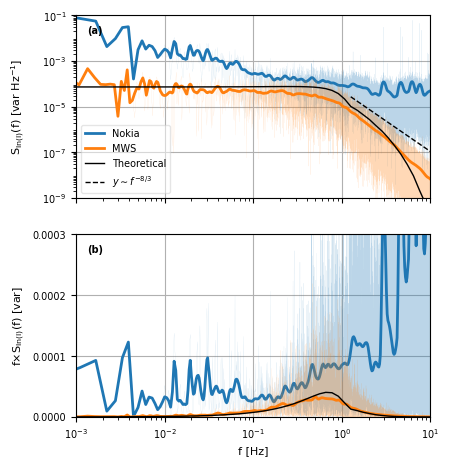

In [ ]:
ticklabel_style = '%H:%M'
ticklabel_rot = 45
ticklabel_ha = 'right'
ticklabel_va = 'center_baseline'
nticks = 7

day_list = pd.date_range(start = '2023-09-12 08:00', end = '2023-10-18 10:00',freq = '1D').strftime('%y%m%d')
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'

#Read Knmi data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')

cutoff = HPF_hz #Hz

for j in day_list[:]:
    print(j)
    store = pd.HDFStore(path_to_proc_data+'Cabauw_'+j+'.h5',mode = 'r')
    Nokia = store['Nokia_AGC_38']
    df_MWS = store['MWS']
    df_Nokia_38 = store['Nokia_AGC_38'].to_frame()
    df_MWS['ln_MWS'] = np.log(df_MWS['MWS'])
    df_Nokia_mw = convert_dB_mW(df_Nokia_38)
    df_Nokia_mw['ln_Nokia'] = np.log(convert_dB_mW(df_Nokia_38))

    
    start_day = pd.to_datetime(j,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = '30min')
    for i in range(18,36):#len(time_range)-1):
        df_met_mean = df_meteo[time_range[i]:time_range[i+1]][1:].mean()
        T_mean = df_met_mean['TA002']
        RH_mean = df_met_mean['RH002']
        u_mean = df_met_mean['F010']
        udir_mean = df_met_mean['D010']
        alpha = 30 #degrees -- anti clockwise from the north
        u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
        v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
        u_perp = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
        P_mean = df_met_mean['RAIN']*3

        f0_Nokia = u_perp/((2*np.pi*Nokialambda*10**-6*L)**0.5)
        f0_MWS = u_perp/((2*np.pi*MWSlambda*10**-6*L)**0.5)
        
        print(time_range[i])
        df_step_Nokia = df_Nokia_mw[time_range[i]:time_range[i+1]][:-1]
        df_step_MWS = df_MWS[time_range[i]:time_range[i+1]][:-1] 
        
        fig,(ax2,ax3) = plt.subplots(nrows = 2,figsize = (12/2.54,12/2.54),sharex=True)

        #Spectrum calculation
        data_MWS = df_step_MWS['ln_MWS'].values
        data_MWS = detrend(data_MWS)
        data_MWS = filtering(data_MWS)*data_MWS
        var_MWS = np.var(data_MWS)
        
        data_Nokia = df_step_Nokia['ln_Nokia'].values
        data_Nokia = detrend(data_Nokia)
        data_Nokia = filtering(data_Nokia)*data_Nokia
        var_Nokia = np.var(data_Nokia)

        #Compute spectra
        X_Nokia,X_2_Nokia,E_Nokia,S_Nokia, freq_Nokia,freq_full_Nokia = spectrum_calc(data_Nokia,sr_Nokia)
        X_MWS,X_2_MWS,E_MWS,S_MWS, freq_MWS,freq_full_MWS = spectrum_calc(data_MWS,sr_MWS)
        f_Nokia_sm,S_Nokia_sm = specsmooth(freq_Nokia,S_Nokia)
        f_MWS_sm,S_MWS_sm = specsmooth(freq_MWS,S_MWS)
       


        data_MWS = df_step_MWS['ln_MWS']
        data_MWS = data_MWS - data_MWS.rolling(window = str(round((1/(cutoff/f0_Nokia*f0_MWS))*1000,0))+'ms',center = True,min_periods = 1).mean()
        Cnn_MWS = variance_to_Cnn(np.nanvar(filtering(data_MWS.values)*data_MWS.values),160*10**9,856)

        f_theo, S_theo, fS_theo = Theoretical_spectrum2(MWSAp,Nokia_f,856,u_perp,Cnn_MWS)
        theo_Cnn = variance_to_Cnn(np.trapz(y = fS_theo, x=np.log(f_theo)),38*10**9,856)
        
        S_theo = S_theo/theo_Cnn*Cnn_MWS
        fS_theo = fS_theo/theo_Cnn*Cnn_MWS

        #Plot spectra Nokia
        ax2.loglog(freq_Nokia,S_Nokia,lw=0.1,color='tab:blue',alpha=0.3)
        ax3.semilogx(freq_Nokia,S_Nokia*freq_Nokia,lw=0.1,color='tab:blue',alpha=0.3)


        #Add smoothed lines
        ax2.loglog(f_Nokia_sm,S_Nokia_sm,lw=2,color='tab:blue',label = 'Nokia')
        ax3.semilogx(f_Nokia_sm,S_Nokia_sm*f_Nokia_sm,lw=2,color='tab:blue',label = 'Nokia')
        
 

        #Add 38 GHz version of MWS and theoretical and fit
        ax2.loglog(freq_MWS/f0_MWS*f0_Nokia,Cnn_to_variance(variance_to_Cnn(S_MWS,160*10**9,850),38*10**9,850),lw=0.1,color='tab:orange',alpha=0.3)
        ax2.loglog(f_MWS_sm/f0_MWS*f0_Nokia,Cnn_to_variance(variance_to_Cnn(S_MWS_sm,160*10**9,850),38*10**9,850),lw=2,color='tab:orange',label = 'MWS')
        ax3.semilogx(freq_MWS/f0_MWS*f0_Nokia,Cnn_to_variance(variance_to_Cnn(S_MWS*freq_MWS,160*10**9,850),38*10**9,850),lw=0.1,color='tab:orange',alpha=0.3)
        ax3.semilogx(f_MWS_sm/f0_MWS*f0_Nokia,Cnn_to_variance(variance_to_Cnn(S_MWS_sm*f_MWS_sm,160*10**9,850),38*10**9,850),lw=2,ls = '-',color='tab:orange',label = 'MWS')
        ax2.loglog(f_theo,S_theo,lw = 1,color = 'k',label = 'Theoretical')
        ax3.semilogx(f_theo,fS_theo,lw = 1,color = 'k',label = 'Theoretical')
        x = np.logspace(0.1,1,5)
        y = 0.5*10**(-4) * x**(-8/3)
        ax2.plot(x,y,ls='--',lw=1,color = 'k', label = r'$y \sim f^{-8/3}$')
        ax2.set_xlim(0.001,10)#sr_MWS/2)
        ax3.set_xlim(0.001,10)#sr_MWS/2)
        
        ax2.set_ylim(10**-9,10**-1)
        ax2.set_yticks([10**-9,10**-7,10**-5,10**-3,10**-1])
        ax3.set_ylim(0,0.3*10**-3)
        ax3.set_yticks([0,0.1*10**-3,0.2*10**-3,0.3*10**-3])#,0.4*10**-3,0.5*10**-3])
        ax3.set_xlabel('f [Hz]',fontsize=8)
        ax2.set_ylabel(r'S$\mathrm{_{ln(I)}}$(f) [var Hz$^{-1}$]',fontsize=8)
        ax3.set_ylabel(r'f$\times$S$\mathrm{_{ln(I)}}$(f) [var]',fontsize=8)
        ax2.grid()
        ax3.grid()
        ax2.legend(fontsize=7,facecolor='white',framealpha=0.5)
        for k in [ax2,ax3]:
            k.tick_params(labelsize=7)

        ax2.text(0.03, 0.9, '(a)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11)
        ax3.text(0.03, 0.9, '(b)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11)
        plt.subplots_adjust(right=0.95,left=0.15,top=0.95,bottom=0.12,wspace=0.6)
        plt.subplots_adjust(left=0.2,bottom = 0.1,right=0.95,top = 0.95)
        string_file = j+'_'+time_range[i].strftime('%H%M')+'-'+time_range[i+1].strftime('%H%M')
        #print(string_file)
        fig.align_ylabels()
        # plt.show()
        plt.savefig(path_to_fig+'Timeseries_Cabauw/'+string_file+'_17_02.pdf')#,dpi=2400)#,transparent=True)
        print(dF_mw)
        plt.close()

# Variance plot

In [ ]:
import warnings
warnings.filterwarnings('ignore')

ticklabel_style = '%H:%M'
ticklabel_rot = 45
ticklabel_ha = 'right'
ticklabel_va = 'center_baseline'
nticks = 7

timestep = '30min'
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
day_list = pd.date_range(start = start_time, end = end_time,freq = '1D').strftime('%y%m%d')

#Read Knmi data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')

df_mw_var = pd.DataFrame(columns = ['Nokia','Nokia_det','Nokia_HPF','MWS','MWS_det','MWS_HPF','Ericsson','Ericsson_det'],index = pd.date_range(start = start_time, end = end_time,freq = '30min'))

cutoff = HPF_hz

for j in day_list:
    print(j)
    store = pd.HDFStore(path_to_proc_data+'Cabauw_'+j+'.h5')
    df_MWS = store['MWS']#.to_frame()
    df_Nokia_38 = store['Nokia_AGC_38'].to_frame()
    #df_Nokia_39 = store['Nokia_AGC_39'].to_frame()
    df_Ericsson_38 = store['Ericsson_38'].to_frame()
    #df_Ericsson_39 = store['Ericsson_39'].to_frame()
    df_MWS['ln_MWS'] = np.log(df_MWS['MWS'])
    df_Nokia_mw = convert_dB_mW(df_Nokia_38)
    df_Nokia_mw['ln_Nokia'] = np.log(convert_dB_mW(df_Nokia_38))
    df_Ericsson_mw = convert_dB_mW(df_Ericsson_38)
    df_Ericsson_mw['ln_Ericsson'] = np.log(convert_dB_mW(df_Ericsson_38))
    
    start_day = pd.to_datetime(j,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = timestep)
    for i in range(0,len(time_range)-1):
        # print(df_meteo[time_range[i]:time_range[i+1]][1:][['F010','D010']])
        df_met_mean = df_meteo[time_range[i]:time_range[i+1]][1:].mean()
        T_mean = df_met_mean['TA002']
        SWD_mean = df_met_mean['SWD']
        RH_mean = df_met_mean['RH002']
        u_mean = df_met_mean['F010']
        udir_mean = df_met_mean['D010']
        alpha = 30 #degrees -- anti clockwise from the north
        u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
        v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
        u_perp = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
        P_mean = df_met_mean['RAIN']*3

        if u_perp == 0:
            u_perp += 0.1
        f0_Nokia = u_perp/((2*np.pi*Nokialambda*10**-6*L)**0.5)
        f0_MWS = u_perp/((2*np.pi*MWSlambda*10**-6*L)**0.5)

        #print(time_range[i])
        df_step_Nokia = df_Nokia_mw[time_range[i]:time_range[i+1]][:-1]
        df_step_Ericsson = df_Ericsson_mw[time_range[i]:time_range[i+1]][:-1]
        df_step_MWS = df_MWS[time_range[i]:time_range[i+1]][:-1]
        #Spectrum calculation
        if (P_mean <= 0.1):# and (SWD_mean >= 50):
            df_mw_var['MWS'].loc[time_range[i+1]] = np.var(df_step_MWS['ln_MWS'].values)
            df_mw_var['Nokia'].loc[time_range[i+1]] = np.var(df_step_Nokia['ln_Nokia'].values)
            df_mw_var['Ericsson'].loc[time_range[i+1]] = np.var(df_step_Ericsson['ln_Ericsson'].values)

            data_MWS = df_step_MWS['ln_MWS'].values
            data_MWS = detrend(data_MWS)
            data_MWS = filtering(data_MWS)*data_MWS
            df_mw_var['MWS_det'].loc[time_range[i+1]] = np.var(data_MWS)
            data_MWS = df_step_MWS['ln_MWS']
            data_MWS_nans = data_MWS.isna().sum()
            data_MWS = data_MWS - data_MWS.rolling(window = str(round((1/(cutoff/f0_Nokia*f0_MWS))*1000,0))+'ms',center = True,min_periods = 1).mean()
            df_mw_var['MWS_HPF'].loc[time_range[i+1]] = np.nanvar(filtering(data_MWS.values)*data_MWS.values)
                
            data_Nokia = df_step_Nokia['ln_Nokia'].values
            data_Nokia = detrend(data_Nokia)
            data_Nokia = filtering(data_Nokia)*data_Nokia
            df_mw_var['Nokia_det'].loc[time_range[i+1]] = np.var(data_Nokia)
            data_Nokia = df_step_Nokia['ln_Nokia']
            data_Nokia_nans = data_Nokia.isna().sum()
            data_Nokia = data_Nokia - data_Nokia.rolling(window = str(round(1/cutoff*1000,0))+'ms',center = True,min_periods = 1).mean()
            df_mw_var['Nokia_HPF'].loc[time_range[i+1]] = np.nanvar(filtering(data_Nokia.values)*data_Nokia.values)

            data_Ericsson = df_step_Ericsson['ln_Ericsson'].values
            data_Ericsson = detrend(data_Ericsson)
            data_Ericsson = filtering(data_Ericsson)*data_Ericsson
            df_mw_var['Ericsson_det'].loc[time_range[i+1]] = np.var(data_Ericsson)

df_mw_var.to_hdf(path_to_proc_data+'var_'+timestep+'_timeseries_14_02.h5',key='var_'+timestep,mode='w')
warnings.filterwarnings('default')


### Nokia

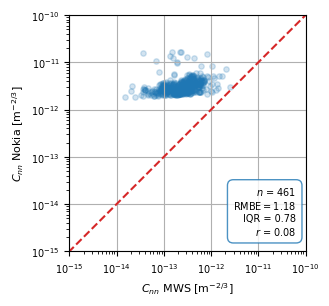

In [4]:
#Read in data (previous cell)
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_14_02_new.h5')['var_'+timestep]
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))


#Merge meteo data with MW data
df_Nokia_meteo = pd.merge(df_mw_var,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['SWD']<20] = np.nan

#Nokia first (ericcson next cell)
df_scatter_Nokia = df_Nokia_meteo.loc[:,['MWS_det','Nokia_det']]
# print(df_scatter_Nokia.index)
# print(df_mw)
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_det'].loc[df_scatter_Nokia['Nokia_det']>0.005] = np.nan
df_scatter_Nokia.dropna(axis=0,how='any',inplace=True)
x_Nokia = df_scatter_Nokia['MWS_det'].values.astype(float)
y_Nokia = df_scatter_Nokia['Nokia_det'].values.astype(float)        

#Figure
size = 15
fig,ax = plt.subplots(figsize = (8/2.54,8/2.54))

#Compute statistics
y = variance_to_Cnn_av(y_Nokia,38*10**9,856,constant_Nokia)
x = variance_to_Cnn_av(df_scatter_Nokia['MWS_det'].values.astype(float),160*10**9,856,constant_MWS)
sigma = (np.var(np.log10(y)-np.log10(x))**0.5)#/np.mean(np.log10(x))*100
bias = (np.sum(np.log10(y)-np.log10(x))/len(x_Nokia))#/np.mean(np.log10(x))*100
corr,_ = pearsonr(np.log10(y),np.log10(x))
corr,_ = pearsonr(np.log10(y),np.log10(x))
iq = np.quantile(np.log10(y)-np.log10(x),0.9) - np.quantile(np.log10(y)-np.log10(x),0.1)
bias = np.mean(np.log10(y)-np.log10(x))

#plotting
ax.scatter(variance_to_Cnn_av(df_scatter_Nokia['MWS_det'].values.astype(float),160*10**9,856,constant_MWS),variance_to_Cnn_av(y_Nokia,38*10**9,856,constant_Nokia),s=size,color='tab:blue',label='Nokia',alpha=0.2)

#Plot 1:1 line
ax.plot([0,1],[0,1],ls = '--',color = 'tab:red',label='1:1')

ax.set_xlabel(r'$C_{nn}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.set_ylabel(r'$C_{nn}$ Nokia [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.grid()
ax.set_ylim(10**-15,10**-10)
ax.set_xlim(10**-15,10**-10)
ax.tick_params(labelsize=7)
ax.ticklabel_format(useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(7)
ax.xaxis.get_offset_text().set_fontsize(7)
ax.set_yscale('log')
ax.set_xscale('log')

#plot Stats
textstr = '\n'.join((r'$n$ = '+str(len(y)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax.text(0.96, 0.06, textstr, transform=ax.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

plt.subplots_adjust(left=0.2,bottom = 0.15,right=0.95,top = 0.9)

# plt.show()
plt.savefig('Figures/Variance_Nokia_MWS_'+timestep+'_24_2_no_correction.png',dpi=2400)#pdf')#,dpi=2400)

### Ericsson

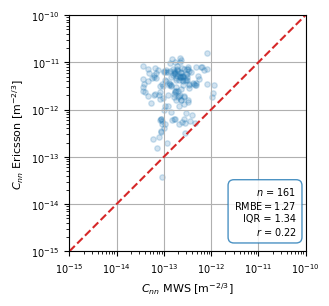

In [5]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_14_02_new.h5')['var_'+timestep]

start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))


#Merge meteo data with MW data
df_Nokia_meteo = pd.merge(df_mw_var,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['MWS_det'].loc[df_Nokia_meteo['SWD']<20] = np.nan

df_scatter_Ericsson = df_Nokia_meteo.loc[:,['MWS_det','Ericsson_det']]
df_scatter_Ericsson['MWS_det'].loc[df_scatter_Ericsson['MWS_det']>0.003] = np.nan
# df_scatter_Ericsson['Ericsson_det'].loc[df_scatter_Ericsson['Ericsson_det']>0.005] = np.nan
df_scatter_Ericsson.dropna(axis=0,how='any',inplace=True)

x_Ericsson = df_scatter_Ericsson['MWS_det'].values.astype(float)
y_Ericsson = df_scatter_Ericsson['Ericsson_det'].values.astype(float)        

size = 15
fig,ax = plt.subplots(figsize = (8/2.54,8/2.54))
y = variance_to_Cnn_av(y_Ericsson,38*10**9,856,constant_Nokia)
x = variance_to_Cnn_av(x_Ericsson,160*10**9,856,constant_MWS)
sigma = (np.var(y-x)**0.5)/np.mean(x)*100
bias = np.mean(np.log10(y)-np.log10(x))
# bias = (np.sum(np.log10(y)-np.log10(x))/len(x_Ericsson))#/np.mean(x)*100
corr,_ = pearsonr(np.log10(y),np.log10(x))
iq = np.quantile(np.log10(y)-np.log10(x),0.9) - np.quantile(np.log10(y)-np.log10(x),0.1)
ax.scatter(variance_to_Cnn_av(x_Ericsson,160*10**9,856,constant_MWS),variance_to_Cnn_av(y_Ericsson,38*10**9,856,constant_Nokia),s=size,color='tab:blue',label='Ericsson',alpha=0.2)

ax.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')

ax.set_xlabel(r'$C_{nn}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.set_ylabel(r'$C_{nn}$ Ericsson [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.grid()
ax.set_ylim(10**-15,10**-10)
ax.set_xlim(10**-15,10**-10)
# ax.legend(fontsize=7)
ax.tick_params(labelsize=7)
ax.ticklabel_format(useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(7)
ax.xaxis.get_offset_text().set_fontsize(7)
ax.set_yscale('log')
ax.set_xscale('log')
textstr = '\n'.join((r'$n$ = '+str(len(y)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax.text(0.96, 0.06, textstr, transform=ax.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

plt.subplots_adjust(left=0.2,bottom = 0.15,right=0.95,top = 0.9)
# plt.show()
plt.savefig('Figures/Variance_Ericsson_MWS_'+timestep+'_24_2.png',dpi=2400)#pdf')#,dpi=2400)

# Splitting data in calibration and validation

In [10]:
start_day_pre, end_day_pre = '2023-09-11 00:00','2023-09-25 11:00'
start_day_post, end_day_post = '2023-09-25 15:00','2023-10-18 00:00'

pre_range = pd.date_range(start = start_day_pre, end = end_day_pre,freq = '30min')
post_range = pd.date_range(start = start_day_post, end = end_day_post,freq = '30min')

#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
df_met_mean['RAIN_30min'] = df_met_mean['RAIN']*3
df_met_mean['RAIN_30min_prev'] = df_met_mean['RAIN_30min'].shift(1)

df_met_mean['cal_val'] = True
df_met_mean['cal_val'].loc[df_met_mean['RAIN_30min']>0.1/2] = np.nan
df_met_mean['cal_val'].loc[df_met_mean['RAIN_30min_prev']>0.1/2] = np.nan
df_met_mean['cal_val'].loc[df_met_mean['F010']>8] = np.nan
df_met_mean['cal_val'].loc[df_met_mean['SWD']<20] = np.nan
df = df_met_mean['cal_val'].dropna()

pre_df = df[:'2023-09-25 11:00'].to_frame()
post_df = df['2023-09-25 15:00':].to_frame()

random.seed(25)
split_pre = np.array(random.choices([1,0],weights = [8,2],k = len(pre_df)))
split_post = np.array(random.choices([1,0],weights = [8,2],k = len(post_df)))
pre_df['cal_val_split'] = split_pre
post_df['cal_val_split'] = split_post

df = pd.concat([pre_df['cal_val_split'],post_df['cal_val_split']],axis=0).asfreq('30min')
# print(df['2023-09-12'])
filename = path_to_proc_data+'cal_val_series_19_02.pkl'
df.to_pickle(filename)

# Constant Noise: Noise determination Before and after movement

<>:81: DeprecationWarning: invalid escape sequence '\m'
<>:81: DeprecationWarning: invalid escape sequence '\m'
/tmp/ipykernel_2523/1733027639.py:81: DeprecationWarning: invalid escape sequence '\m'
  textstr = '\n'.join((r'$n$ = '+str(len(y)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
/tmp/ipykernel_2523/1733027639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
/tmp/ipykernel_2523/1733027639.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scatter_Nokia['Nokia_det'].l

2.4228853242850232e-12 2.019548874685014e-12
81 81


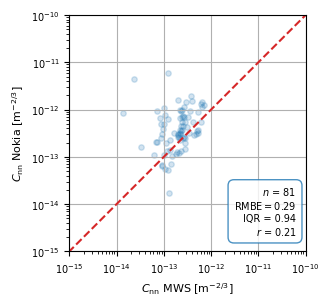

In [96]:
quantile = 0.07
timestep = '30min'

df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_14_02_new.h5')['var_'+timestep] #with HPF and Ericsson
df_cal_val = pd.read_pickle(path_to_proc_data+'cal_val_series_19_02.pkl')

df_mw_var = pd.merge(df_mw_var,df_cal_val,how = 'outer',left_index=True,right_index=True)

df_scatter_Nokia = df_mw_var.loc[:,['MWS_det','Nokia_det','MWS_HPF','Nokia_HPF','cal_val_split']]
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_det'].loc[df_scatter_Nokia['Nokia_det']>0.005] = np.nan
# print(df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det'] == np.nanmin(df_scatter_Nokia['MWS_det'].values)])
df_scatter_Nokia.dropna(axis=0,how='any',inplace=True)

x_bef = np.array(variance_to_Cnn_av(df_scatter_Nokia['MWS_HPF'][:'2023-09-25 11:00'].values.astype(float),160*10**9,856,constant_MWS))
x_aft = np.array(variance_to_Cnn_av(df_scatter_Nokia['MWS_HPF']['2023-09-25 15:00':].values.astype(float),160*10**9,856,constant_MWS))
y_bef = np.array(variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF'][:'2023-09-25 11:00'].values.astype(float),38*10**9,856,constant_Nokia))
y_aft = np.array(variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF']['2023-09-25 15:00':].values.astype(float),38*10**9,856,constant_Nokia))

#split in validation and testing
split_bef = np.array(df_scatter_Nokia['cal_val_split'][:'2023-09-25 11:00'].values)
split_aft = np.array(df_scatter_Nokia['cal_val_split']['2023-09-25 15:00':].values)
x_bef_cal = x_bef[split_bef == 1]
x_bef_val = x_bef[split_bef == 0]
x_aft_cal = x_aft[split_aft == 1]
x_aft_val = x_aft[split_aft == 0]
y_bef_cal = y_bef[split_bef == 1]
y_bef_val = y_bef[split_bef == 0]
y_aft_cal = y_aft[split_aft == 1]
y_aft_val = y_aft[split_aft == 0]

#denoise validation based on calibration
y_bef_cal,quant_bef_cal = denoise(y_bef_cal,quantile,'lin')
y_aft_cal,quant_aft_cal = denoise(y_aft_cal,quantile,'lin')
y_bef_val = y_bef_val - quant_bef_cal
y_aft_val = y_aft_val - quant_aft_cal

print(quant_bef_cal,quant_aft_cal)
y_val = np.concatenate([y_bef_val,y_aft_val])
x_val = np.concatenate([x_bef_val,x_aft_val])
y_cal = np.concatenate([y_bef_cal,y_aft_cal])
x_cal = np.concatenate([x_bef_cal,x_aft_cal])

#Remove nans and zeroes
x_val = x_val[~np.isnan(np.log10(y_val))]
y_val = y_val[~np.isnan(np.log10(y_val))]
y_val = y_val[~np.isnan(np.log10(x_val))]
x_val = x_val[~np.isnan(np.log10(x_val))]
x_cal = x_cal[~np.isnan(np.log10(y_cal))]
y_cal = y_cal[~np.isnan(np.log10(y_cal))]
y_cal = y_cal[~np.isnan(np.log10(x_cal))]
x_cal = x_cal[~np.isnan(np.log10(x_cal))]

y,x = y_val,x_val
x = x[y!=0]
y = y[y!=0]
y = y[x!=0]
x = x[x!=0]
print(len(y),len(x))

size = 15
fig,ax = plt.subplots(figsize = (8/2.54,8/2.54))
sigma = (np.var(np.log10(y)-np.log10(x))**0.5)#/np.mean(np.log10(x))*100
bias = (np.sum(np.log10(y)-np.log10(x))/len(x))#/np.mean(np.log10(x))*100
corr,_ = pearsonr(np.log10(y),np.log10(x))
iq = np.quantile(np.log10(y)-np.log10(x),0.9) - np.quantile(np.log10(y)-np.log10(x),0.1)
bias = np.mean(np.log10(y)-np.log10(x))
ax.scatter(x,y,s=size,color='tab:blue',label='Nokia',alpha=0.2)
ax.plot([0,1],[0,1],ls = '--',color = 'tab:red',label='1:1')
ax.set_xlabel(r'$C_{\mathrm{nn}}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.set_ylabel(r'$C_{\mathrm{nn}}$ Nokia [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.grid()
ax.set_ylim(10**-15,10**-10)
ax.set_xlim(10**-15,10**-10)
ax.tick_params(labelsize=7)
ax.ticklabel_format(useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(7)
ax.xaxis.get_offset_text().set_fontsize(7)
ax.set_yscale('log')
ax.set_xscale('log')
textstr = '\n'.join((r'$n$ = '+str(len(y)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax.text(0.96, 0.06, textstr, transform=ax.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)
plt.subplots_adjust(left = 0.2,right=0.95,top = 0.94,bottom = 0.2)
plt.subplots_adjust(left=0.2,bottom = 0.15,right=0.95,top = 0.9)
# ax.set_aspect('equal')
# plt.show()
plt.savefig('Figures/Variance_Nokia_MWS_'+timestep+'_SWD_19_02_rel_val.pdf')

#Store
stats_dict = {'Pre_Cnn':quant_bef_cal,'Post_Cnn':quant_aft_cal}
with open(path_to_proc_data+'constant_noise_19_02.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

## Test sensitivity to quantile

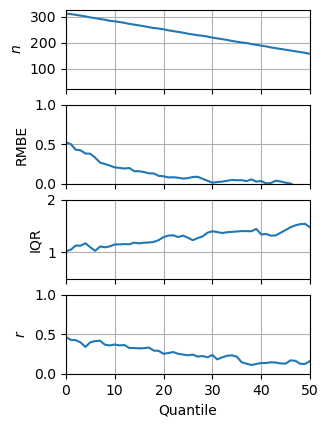

In [22]:
quant_list = np.arange(0.0,.9,0.01)
n_list = []
r_list = []
RMBE_list = []
IQR_list = []

timestep = '30min'
# df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_15_11.h5')['var_'+timestep] #original one
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_14_02_new.h5')['var_'+timestep] #with HPF
df_cal_val = pd.read_pickle(path_to_proc_data+'cal_val_series_19_02.pkl')

df_mw_var = pd.merge(df_mw_var,df_cal_val,how = 'outer',left_index=True,right_index=True)

df_scatter_Nokia = df_mw_var.loc[:,['MWS_det','Nokia_det','MWS_HPF','Nokia_HPF','cal_val_split']]
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan
df_scatter_Nokia['Nokia_det'].loc[df_scatter_Nokia['Nokia_det']>0.005] = np.nan
df_scatter_Nokia.dropna(axis=0,how='any',inplace=True)

x_bef = np.array(variance_to_Cnn_av(df_scatter_Nokia['MWS_HPF'][:'2023-09-25 11:00'].values.astype(float),160*10**9,856,constant_MWS))
x_aft = np.array(variance_to_Cnn_av(df_scatter_Nokia['MWS_HPF']['2023-09-25 15:00':].values.astype(float),160*10**9,856,constant_MWS))
y_bef = np.array(variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF'][:'2023-09-25 11:00'].values.astype(float),38*10**9,856,constant_Nokia))
y_aft = np.array(variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF']['2023-09-25 15:00':].values.astype(float),38*10**9,856,constant_Nokia))

#split in validation and testing
split_bef = np.array(df_scatter_Nokia['cal_val_split'][:'2023-09-25 11:00'].values)
split_aft = np.array(df_scatter_Nokia['cal_val_split']['2023-09-25 15:00':].values)
x_bef_cal = x_bef[split_bef == 1]
x_bef_val = x_bef[split_bef == 0]
x_aft_cal = x_aft[split_aft == 1]
x_aft_val = x_aft[split_aft == 0]
y_bef_cal = y_bef[split_bef == 1]
y_bef_val = y_bef[split_bef == 0]
y_aft_cal = y_aft[split_aft == 1]
y_aft_val = y_aft[split_aft == 0]

for i in quant_list:
    #denoise validation based on calibration
    y_bef_cal,quant_bef_cal = denoise(y_bef_cal,i,'lin')
    y_aft_cal,quant_aft_cal = denoise(y_aft_cal,i,'lin')
    y_bef_val = y_bef_val - quant_bef_cal
    y_aft_val = y_aft_val - quant_aft_cal
    
    # print(quant_bef_cal,quant_aft_cal)
    y_val = np.concatenate([y_bef_val,y_aft_val])
    x_val = np.concatenate([x_bef_val,x_aft_val])
    y_cal = np.concatenate([y_bef_cal,y_aft_cal])
    x_cal = np.concatenate([x_bef_cal,x_aft_cal])
    # print(len(y_val),len(x_val))
    
    #Remove nans and zeroes
    x_val = x_val[~np.isnan(np.log10(y_val))]
    y_val = y_val[~np.isnan(np.log10(y_val))]
    y_val = y_val[~np.isnan(np.log10(x_val))]
    x_val = x_val[~np.isnan(np.log10(x_val))]
    x_cal = x_cal[~np.isnan(np.log10(y_cal))]
    y_cal = y_cal[~np.isnan(np.log10(y_cal))]
    y_cal = y_cal[~np.isnan(np.log10(x_cal))]
    x_cal = x_cal[~np.isnan(np.log10(x_cal))]
    
    y,x = y_cal,x_cal
    x = x[y!=0]
    y = y[y!=0]
    y = y[x!=0]
    x = x[x!=0]
    
    sigma = (np.var(np.log10(y)-np.log10(x))**0.5)#/np.mean(np.log10(x))*100
    bias = (np.sum(np.log10(y)-np.log10(x))/len(x))#/np.mean(np.log10(x))*100
    corr,_ = pearsonr(np.log10(y),np.log10(x))
    iq = np.quantile(np.log10(y)-np.log10(x),0.9) - np.quantile(np.log10(y)-np.log10(x),0.1)
    RMBE_list.append(bias)
    r_list.append(corr)
    IQR_list.append(iq)
    n_list.append(len(y))

q_sm,RMBE_sm = specsmooth(quant_list,RMBE_list,1)
RMBE_grad = np.gradient(RMBE_sm.ravel(),q_sm.ravel())
RMBE_grad2 = np.gradient(RMBE_grad,q_sm.ravel())
RMBE_grad3 = np.gradient(RMBE_grad2,q_sm.ravel())

fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4,sharex=True,figsize=(8/2.54,12/2.54))
ax1.plot(quant_list*100,n_list)
ax2.plot(quant_list*100,np.array(RMBE_list))#/np.array(n_list))
ax3.plot(quant_list*100,IQR_list)
ax4.plot(quant_list*100,r_list)
ax4.set_xlabel('Quantile')
ax1.set_ylabel(r'$n$')
ax2.set_ylabel(r'RMBE')
ax3.set_ylabel('IQR')
ax4.set_ylabel(r'$r$')

ax2.set_ylim(0,1)
ax3.set_ylim(0.5,2)
ax4.set_ylim(0,1)
ax4.set_xlim(0,50)
for i in [ax1,ax2,ax3,ax4]:
    i.grid()
plt.show()


# Spectral Noise

## First determine variance per frequency band

In [25]:
timestep = '30min'
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
day_list = pd.date_range(start = start_time, end = end_time,freq = '1D').strftime('%y%m%d')
bounds = np.hstack([HPF_hz,np.logspace(-1.6,1,endpoint = True,num=14)])
bounds_str = [str(round(i,2)) for i in np.log10(bounds)] #because 0.25 was written as 0.249999999999
print(bounds_str)

#Read Knmi data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')

df_mw_var = pd.DataFrame(columns = ['MWS','Nokia','Nokia_HPF','MWS_HPF'],index = pd.date_range(start = start_time, end = end_time,freq = timestep))
for i in range(0,len(bounds)):
    #print(bounds_str[i])
    if i == 0:
        string_suffix = 'inf_'+bounds_str[i]
    else:
        string_suffix = bounds_str[i-1]+'_'+bounds_str[i]
    df_mw_var['Nokia_'+string_suffix] = np.nan
    df_mw_var['MWS_'+string_suffix] = np.nan

cutoff = HPF_hz

for j in day_list[:]:
    print(j)
    store = pd.HDFStore(path_to_proc_data+'Cabauw_'+j+'.h5',mode = 'r')
    df_MWS = store['MWS']#.to_frame()
    df_Nokia_38 = store['Nokia_AGC_38'].to_frame()
    df_MWS['ln_MWS'] = np.log(df_MWS['MWS'])
    df_Nokia_mw = convert_dB_mW(df_Nokia_38)
    df_Nokia_mw['ln_Nokia'] = np.log(convert_dB_mW(df_Nokia_38))
    
    start_day = pd.to_datetime(j,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = timestep)
    for i in range(0,len(time_range)-1):
        # print(time_range[i])
        df_met_mean = df_meteo[time_range[i]:time_range[i+1]][1:].mean()
        T_mean = df_met_mean['TA002']
        RH_mean = df_met_mean['RH002']
        u_mean = df_met_mean['F010']
        udir_mean = df_met_mean['D010']
        SWD_mean = df_met_mean['SWD']
        alpha = 30 #degrees -- anti clockwise from the north
        u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
        v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
        u_perp = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
        P_mean = df_met_mean['RAIN']*3

        if u_perp == 0:
            u_perp += 0.1

        f0_Nokia = u_perp/((2*np.pi*Nokialambda*10**-6*L)**0.5)
        f0_MWS = u_perp/((2*np.pi*MWSlambda*10**-6*L)**0.5)

        if (P_mean <= 0.1):
            df_step_Nokia = df_Nokia_mw[time_range[i]:time_range[i+1]][:-1]
            df_step_MWS = df_MWS[time_range[i]:time_range[i+1]][:-1]
            df_mw_var['MWS'].loc[time_range[i+1]] = np.var(df_step_MWS['ln_MWS'].values)
            df_mw_var['Nokia'].loc[time_range[i+1]] = np.var(df_step_Nokia['ln_Nokia'].values)

            #Compute MWS
            data_MWS = df_step_MWS['ln_MWS']
            data_MWS = data_MWS - data_MWS.rolling(window = str(round((1/(cutoff/f0_Nokia*f0_MWS))*1000,0))+'ms',center = True,min_periods = 1).mean()
            data_MWS = filtering(data_MWS.values)*data_MWS.values

            
            if len(data_MWS) > 0:
                X_MWS,X_2_MWS,E_MWS,S_MWS, freq_MWS,freq_full_MWS = spectrum_calc(data_MWS,sr_MWS)
                f_MWS_Nokia = freq_MWS/f0_MWS*f0_Nokia
                E_MWS[E_MWS == 0] = np.nan
                for k in range(0,len(bounds)):
                    if k == 0:
                        index_2_MWS = abs(f_MWS_Nokia-bounds[k]).argmin()
                        string_suffix = 'inf_'+bounds_str[k]
                        df_mw_var['MWS_'+string_suffix].loc[time_range[i+1]] = \
                            Cnn_to_variance_av(variance_to_Cnn_av(np.sum(E_MWS[:index_2_MWS]),160*10**9,856,constant_MWS),
                                               38*10**9,856,constant_Nokia)
                    else:
                        index_1_MWS = abs(f_MWS_Nokia-bounds[k-1]).argmin()
                        index_2_MWS = abs(f_MWS_Nokia-bounds[k]).argmin()
                        string_suffix = bounds_str[k-1]+'_'+bounds_str[k]
                        df_mw_var['MWS_'+string_suffix].loc[time_range[i+1]] = \
                            Cnn_to_variance_av(variance_to_Cnn_av(np.sum(E_MWS[index_1_MWS:index_2_MWS]),160*10**9,856,constant_MWS),
                                               38*10**9,856,constant_Nokia)
            
            #Compute Nokia
            data_Nokia = df_step_Nokia['ln_Nokia']
            data_Nokia = data_Nokia - data_Nokia.rolling(window = str(round(1/cutoff*1000,0))+'ms',center = True,min_periods = 1).mean()
            data_Nokia = filtering(data_Nokia.values)*data_Nokia.values
            if len(data_Nokia) > 0:
                X_Nokia,X_2_Nokia,E_Nokia,S_Nokia, freq_Nokia,freq_full_Nokia = spectrum_calc(data_Nokia,sr_Nokia)
                E_Nokia[E_Nokia == 0] = np.nan
                for k in range(0,len(bounds)):
                    if k == 0:
                        index_2_Nokia = abs(freq_Nokia-bounds[k]).argmin()
                        string_suffix = 'inf_'+bounds_str[k]
                        df_mw_var['Nokia_'+string_suffix].loc[time_range[i+1]] = np.sum(E_Nokia[:index_2_Nokia])#/freq_Nokia[:index_2_Nokia])
                    else:
                        index_1_Nokia = abs(freq_Nokia-bounds[k-1]).argmin()
                        index_2_Nokia = abs(freq_Nokia-bounds[k]).argmin()
                        string_suffix = bounds_str[k-1]+'_'+bounds_str[k]
                        df_mw_var['Nokia_'+string_suffix].loc[time_range[i+1]] = np.sum(E_Nokia[index_1_Nokia:index_2_Nokia])#/freq_Nokia[index_1_Nokia:index_2_Nokia])

            df_mw_var['Nokia_HPF'].loc[time_range[i+1]] = np.var(data_Nokia)
            df_mw_var['MWS_HPF'].loc[time_range[i+1]] = np.var(data_MWS)
df_mw_var.to_hdf(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_MWS_38GHz_17_02.h5',key='var_'+timestep,mode='w')


['-1.82', '-1.6', '-1.4', '-1.2', '-1.0', '-0.8', '-0.6', '-0.4', '-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
230911
230912
230913
230914
230915
230916
230917
230918
230919
230920
230921
230922
230923
230924
230925
230926
230927
230928
230929
230930
231001
231002
231003
231004
231005
231006
231007
231008
231009
231010
231011
231012
231013
231014
231015
231016
231017
231018


In [24]:
df_mw_var.to_hdf(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_MWS_38GHz_17_02_new.h5',key='var_'+timestep,mode='w')

### Before

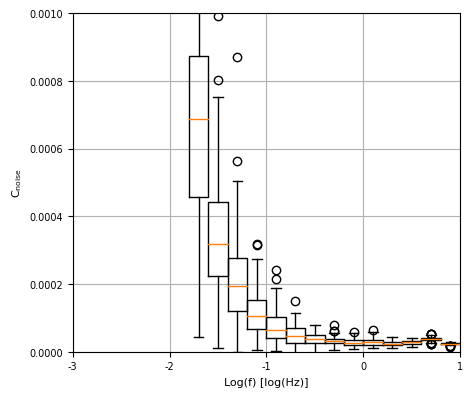

(5, 118)
Mean: 2.868185833890456e-05
Median: 2.6357767652545993e-05


In [23]:
#Read in data
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_MWS_38GHz_17_02.h5')['var_'+timestep]
df_cal_val = pd.read_pickle(path_to_proc_data+'cal_val_series_19_02.pkl')

df_mw_var = pd.merge(df_mw_var,df_cal_val,how = 'outer',left_index=True,right_index=True)

#Determine boundaries for plotting
bounds = np.hstack([HPF_hz,np.logspace(-1.6,1,endpoint = True,num=14)])
bounds_str = [str(round(i,2)) for i in np.log10(bounds)] #because 0.25 was written as 0.249999999999
colormap = LinearSegmentedColormap.from_list("djl_1", ['#ffffd9', '#081d58'])

#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))


df_scatter_Nokia = df_mw_var.loc[:'2023-09-25 00:00',:]
df_scatter_Nokia = df_scatter_Nokia.loc[df_scatter_Nokia['cal_val_split'] == 1]
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>0.003] = np.nan


#Merge meteo data with MW data and filter data
df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['F010']>8] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['MWS_HPF'].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan #moment of shift
df_Nokia_meteo.dropna(axis=0,how='any',inplace=True)


#create figure
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (12/2.54,10/2.54))#,sharex=True,sharey=True)

#Compute difference between MWS and Nokia as sigma noise. 
c_array = []
for k in range(1,len(bounds)):
    if k == 0:
        string_suffix = 'inf_'+bounds_str[k]
        string_label = r'log(f) < '+bounds_str[k]
        MWS = df_Nokia_meteo['MWS_'+string_suffix].values.astype(float)
        y_Nokia = df_Nokia_meteo['Nokia_'+string_suffix].values.astype(float)-MWS
        f0 = 1/1800
        f1 = bounds[k]
        width = 1
        position = np.round([np.log10(bounds[k])],2)-width/2
    else:
        string_suffix = bounds_str[k-1]+'_'+bounds_str[k]
        string_label = bounds_str[k-1]+r' < log(f) < '+bounds_str[k]
        MWS = df_Nokia_meteo['MWS_'+string_suffix].values.astype(float)
        y_Nokia = df_Nokia_meteo['Nokia_'+string_suffix].values.astype(float)-MWS

        #For plotting
        f0 = bounds[k-1]
        f1 = bounds[k]
        width = 0.2
        position = np.round([np.log10(bounds[k])],2)-width/2
    c_Nokia = y_Nokia/(np.log(10)*(f1-f0))
    #Add if above 1 Hz
    if (np.log10(bounds[k-1]) >= 0) and (k > 0):
        c_array.append(c_Nokia)
    bp = ax.boxplot(c_Nokia,positions = position,widths = width,zorder=3)
ax.grid(zorder=0)
ax.set_ylim(0,0.001)
ax.set_xlim(-3,1)
ax.set_xticks([-3,-2,-1,0,1],labels = ['-3','-2','-1','0','1'])
ax.set_xlabel('Log(f) [log(Hz)]',fontsize = 8)
ax.set_ylabel(r'C$_{\mathrm{noise}}$',fontsize= 8)#$\sigma_{\mathrm{Nokia}}^2$ - $\sigma_{\mathrm{MWS 38GHz}}^2$ [var]',fontsize=8)

ax.tick_params(labelsize = 7)
plt.subplots_adjust(left = 0.15,right = 0.97,top=0.95,bottom = 0.09,wspace=0.15,hspace=0.3)
plt.show()
# plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Freq_dependence/Noise/Noise_vs_freq_normalised_pre_movement_corrected_20_12.png',dpi=300)

print(np.shape(c_array))
print('Mean: '+str(np.mean(c_array)))
print('Median: '+str(np.median(c_array)))

#Store
stats_dict = {'Mean':np.mean(c_array),'Median':np.median(c_array)}
with open(path_to_proc_data+'c_noise_dict_pre_mov_corrected_19_02.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

### After

0.0
0.19999999999999996
0.3999999999999999
0.6000000000000001
0.8000000000000003


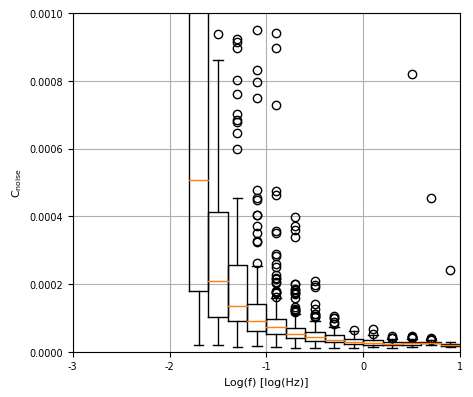

Mean: 3.3240757132020084e-05
Median: 2.415027235073579e-05


In [7]:
#Read in data
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_MWS_38GHz_17_02.h5')['var_'+timestep]
df_cal_val = pd.read_pickle(path_to_proc_data+'cal_val_series_19_02.pkl')

df_mw_var = pd.merge(df_mw_var,df_cal_val,how = 'outer',left_index=True,right_index=True)

#Determine boundaries for plotting
bounds = np.hstack([HPF_hz,np.logspace(-1.6,1,endpoint = True,num=14)])
bounds_str = [str(round(i,2)) for i in np.log10(bounds)] #because 0.25 was written as 0.249999999999
colormap = LinearSegmentedColormap.from_list("djl_1", ['#ffffd9', '#081d58'])

#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))

df_scatter_Nokia = df_mw_var.loc['2023-09-25 15:00':,:]
df_scatter_Nokia = df_scatter_Nokia.loc[df_scatter_Nokia['cal_val_split'] == 1]
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>0.003] = np.nan
df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['F010']>8] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['MWS_HPF'].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan
df_Nokia_meteo.dropna(axis=0,how='any',inplace=True)

fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (12/2.54,10/2.54))#,sharex=True,sharey=True)

c_array = []
for k in range(1,len(bounds)):
    if k == 0:
        string_suffix = 'inf_'+bounds_str[k]
        string_label = r'log(f) < '+bounds_str[k]
        MWS = df_Nokia_meteo['MWS_'+string_suffix].values.astype(float)
        y_Nokia = df_Nokia_meteo['Nokia_'+string_suffix].values.astype(float)-MWS
        f0 = 1/1800
        f1 = bounds[k]
        width = 1
        position = np.round([np.log10(bounds[k])],2)-width/2
    else:
        string_suffix = bounds_str[k-1]+'_'+bounds_str[k]
        string_label = bounds_str[k-1]+r' < log(f) < '+bounds_str[k]
        MWS = df_Nokia_meteo['MWS_'+string_suffix].values.astype(float)
        y_Nokia = df_Nokia_meteo['Nokia_'+string_suffix].values.astype(float)#-MWS
        f0 = bounds[k-1]
        f1 = bounds[k]
        width = 0.2
        position = np.round([np.log10(bounds[k])],2)-width/2
    c_Nokia = y_Nokia/(np.log(10)*(f1-f0)) #difference still has to be recomputed to entire frequency range
    if (np.log10(bounds[k-1]) >= 0) and (k > 0):
        print(np.log10(bounds[k-1]))
        c_array.append(c_Nokia)
    bp = ax.boxplot(c_Nokia,positions = position,widths = width,zorder=3)
ax.grid(zorder=0)
ax.set_ylim(0,0.001)
ax.set_xlim(-3,1)
ax.set_xticks([-3,-2,-1,0,1],labels = ['-3','-2','-1','0','1'])
ax.set_xlabel('Log(f) [log(Hz)]',fontsize = 8)
ax.set_ylabel(r'C$_{\mathrm{noise}}$',fontsize= 8)#$\sigma_{\mathrm{Nokia}}^2$ - $\sigma_{\mathrm{MWS 38GHz}}^2$ [var]',fontsize=8)

ax.tick_params(labelsize = 7)
plt.subplots_adjust(left = 0.15,right = 0.97,top=0.95,bottom = 0.09,wspace=0.15,hspace=0.3)
plt.show()
# plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Freq_dependence/Noise/Noise_vs_freq_normalised_post_movement_corrected_20_12.png',dpi=300)


print('Mean: '+str(np.mean(c_array)))
print('Median: '+str(np.median(c_array)))

# stats_dict = {'Mean':np.mean(c_array),'Median':np.median(c_array)}
# with open(path_to_proc_data+'c_noise_dict_post_mov_corrected_19_02.pkl', 'wb') as f:
#     pickle.dump(stats_dict, f)

## Then selecting parts of spectrum well-functioning

0_1
1_2
2_3
3_4
4_5
5_6
6_7


IndexError: list index out of range

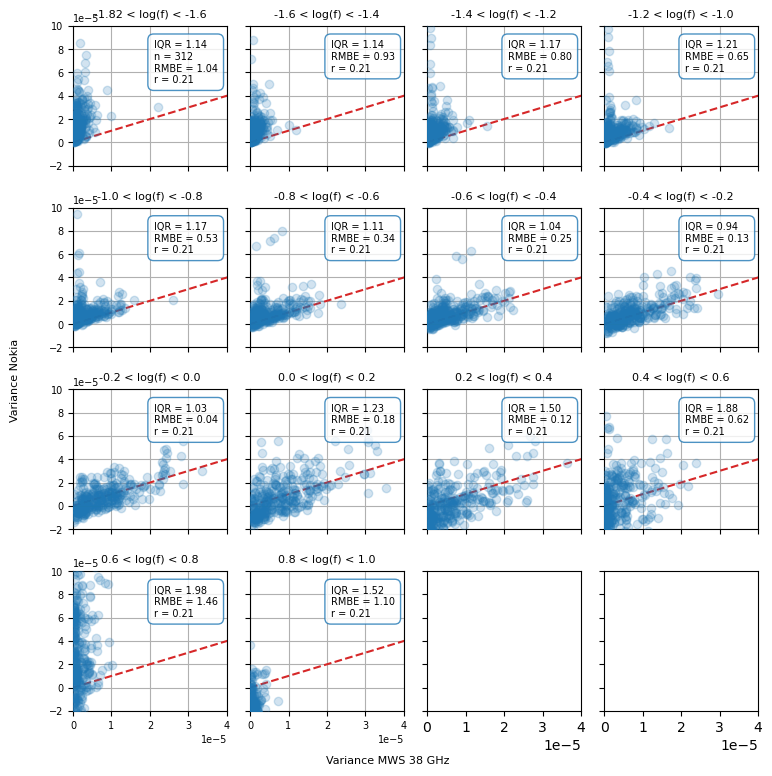

In [77]:
variable = ['D010', 'F010', 'P0', 'RAIN', 'RH002','Q002', 'TA002','TA000', 'TD002', 'ZMA', 'LWD', 'LWU', 'SWD', 'SWU', 'time', 'doy', 'u_perp']
timestep = '30min'
# df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_MWS_38GHz_23_11.h5')['var_'+timestep]
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_MWS_38GHz_17_02.h5')['var_'+timestep]
df_cal_val = pd.read_pickle(path_to_proc_data+'cal_val_series_19_02.pkl')

df_mw_var = pd.merge(df_mw_var,df_cal_val,how = 'outer',left_index=True,right_index=True)

bounds = np.hstack([HPF_hz,np.logspace(-1.6,1,endpoint = True,num=14)])
bounds_str = [str(round(i,2)) for i in np.log10(bounds)] #because 0.25 was written as 0.249999999999
u_bounds = [0,1,2,3,4,5,6,7]#,8,10,12]
colormap = LinearSegmentedColormap.from_list("djl_1", ['#ffffd9', '#081d58'])

#Read Noise
with open(path_to_proc_data+'c_noise_dict_post_mov_corrected_19_02.pkl', 'rb') as f:
    dict_noise = pickle.load(f)
c_noise_post = dict_noise['Median'] 

with open(path_to_proc_data+'c_noise_dict_pre_mov_corrected_19_02.pkl', 'rb') as f:
    dict_noise = pickle.load(f)
c_noise_pre = dict_noise['Median'] 

#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))

df_scatter_Nokia = df_mw_var.loc[:,:]
df_scatter_Nokia['c_noise'] = np.nan
df_scatter_Nokia['c_noise'].loc[:'2023-09-25 11:00'] = c_noise_pre
df_scatter_Nokia['c_noise'].loc['2023-09-25 15:00':] = c_noise_post
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>0.003] = np.nan
df_scatter_Nokia['Nokia_HPF'].loc[df_scatter_Nokia['Nokia_HPF']>0.005] = np.nan
df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
# print(df_Nokia_meteo.keys())
# print(df_scatter_Nokia['2023-10-16'])
# print(df_Nokia_meteo['RAIN']['2023-10-16'])
# print(df_mw)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo = df_Nokia_meteo.loc[df_Nokia_meteo['cal_val_split'] == 1]
df_Nokia_meteo.dropna(axis=0,how='any',inplace=True)

# x_Nokia = Cnn_to_variance(variance_to_Cnn(df_Nokia_meteo['MWS_det'].values.astype(float),160*10**9,850),38*10**9,850)
#y_Nokia = df_Nokia_meteo['Nokia_det'].values.astype(float)


for i in range(1,len(u_bounds)+1): #start at 1 --> 0-1 m s-1
    if i == len(u_bounds):
        data = df_Nokia_meteo.copy()
    else:
        data = df_Nokia_meteo.loc[(df_Nokia_meteo['u_perp']>u_bounds[i-1]) & (df_Nokia_meteo['u_perp']<u_bounds[i])]
    fig,ax = plt.subplots(nrows = 4,ncols = 4,figsize = (20/2.54,20/2.54),sharex=True,sharey=True)
    ax = ax.ravel()
    for k in range(1,len(bounds)):
        if k == 0:
            string_suffix = 'inf_'+bounds_str[k]
            string_label = r'log(f) < '+bounds_str[k]
            x_MWS = data['MWS_'+string_suffix].values.astype(float)
            y_Nokia = data['Nokia_'+string_suffix].values.astype(float)

        else:
            f0 = bounds[k-1]
            f1 = bounds[k]
            var_corr = data['c_noise'].values*(np.log(10)*(f1-f0))
            string_suffix = bounds_str[k-1]+'_'+bounds_str[k]
            string_label = bounds_str[k-1]+r' < log(f) < '+bounds_str[k]
            x_MWS = data['MWS_'+string_suffix].values.astype(float)
            y_Nokia = data['Nokia_'+string_suffix].values.astype(float) - var_corr
            # print(np.max(y_Nokia),np.argmax(y_Nokia),data.index[np.argmax(y_Nokia)])
            # print(df_mw)

        sc = ax[k-1].scatter(x_MWS,y_Nokia,alpha=0.2,color='tab:blue',zorder=3)# c,cmap = 'viridis')
        ax[k-1].plot([0,1],[0,1],ls = '--',color = 'tab:red',label='1:1')
        ax[k-1].set_title(string_label,fontsize=8)
        #ax[k-1].set_aspect('equal')
        ax[k-1].grid(zorder=0)
        ax[k-1].set_ylim(-0.00002,0.0001)
        ax[k-1].set_xlim(0,0.00004)#Cnn_to_variance(variance_to_Cnn(0.0004,160*10**9,850),38*10**9,850))
        # ax.legend()
        ax[k-1].tick_params(labelsize = 7)
        ax[k-1].xaxis.offsetText.set_fontsize(7)
        # ax[k-1].ticklabel_format(useMathText=True)
        ax[k-1].yaxis.offsetText.set_fontsize(7)
        # ax[k-1].set_xscale('log')
        # ax[k-1].set_yscale('log')
        # ax[k-1].ticklabel_format(useMathText=True)
        x_MWS = x_MWS[y_Nokia > 0] 
        y_Nokia = y_Nokia[y_Nokia > 0]
        sigma = (np.var(y_Nokia-x_MWS)**0.5)/np.mean(x_MWS)*100
        RMSE = np.sqrt(np.sum((y_Nokia-x_MWS)**2)/len(y_Nokia))
        # bias = np.nanmean(np.log10(variance_to_Cnn_av(y_Nokia,38*10**9,856,constant_Nokia))-np.log10(variance_to_Cnn_av(x_MWS,38*10**9,856,constant_MWS)))
        bias = np.nanmean(np.log10(y_Nokia)-np.log10(x_MWS))
        # r,_ = pearsonr(np.log10(y_Nokia),np.log10(x_MWS))
        # print(np.log10(y_Nokia),y_Nokia)
        # iq = np.nanquantile(np.log10(variance_to_Cnn_av(y_Nokia,38*10**9,856,constant_Nokia))-np.log10(variance_to_Cnn_av(x_MWS,38*10**9,856,constant_MWS)),0.9) - \
        #      np.nanquantile(np.log10(variance_to_Cnn_av(y_Nokia,38*10**9,856,constant_Nokia))-np.log10(variance_to_Cnn_av(x_MWS,38*10**9,856,constant_MWS)),0.1)
        iq = np.nanquantile(np.log10(y_Nokia)-np.log10(x_MWS),0.9) - np.nanquantile(np.log10(y_Nokia)-np.log10(x_MWS),0.1)
        if k == 1:
            textstr = '\n'.join((r'IQR = '+'{:.2f}'.format(iq),'n = '+str(len(x_MWS)),'RMBE = '+'{:.2f}'.format(bias),'r = '+'{:.2f}'.format(r)))
        else:
            textstr = '\n'.join((r'IQR = '+'{:.2f}'.format(iq),'RMBE = '+'{:.2f}'.format(bias),'r = '+'{:.2f}'.format(r)))
                        
            # place a text box in upper left in axes coords
        ax[k-1].text(0.94, 0.9, textstr, transform=ax[k-1].transAxes, fontsize=7,
                verticalalignment='top',horizontalalignment='right',multialignment = 'left', bbox=props,zorder=6)
    
    fig.supylabel('Variance Nokia',fontsize=8)
    fig.supxlabel('Variance MWS 38 GHz',fontsize=8)
    plt.subplots_adjust(left = 0.1,right = 0.97,top=0.95,bottom = 0.08,wspace=0.15,hspace=0.3)
    if i == len(u_bounds):
        plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Freq_dependence/Wind_classes/Freq_var_Nokia_MWS_38GHz_'+timestep+'_f_noise_substraction_rel_19_02_20.png',dpi=300)
    else:
        plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Freq_dependence/Wind_classes/Freq_var_Nokia_MWS_38GHz_'+timestep+'_f_noise_substraction_'+str(u_bounds[i-1])+'_'+str(u_bounds[i])+'_19_02_zoomed_rel_20.png',dpi=300)
    print(str(u_bounds[i-1])+'_'+str(u_bounds[i]))
    # print(df_mw)
    plt.close()

# Comparison versus MWS and EC

## Parallel

In [84]:
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'
end_day = '2023-10-18 00:00'
day_list = pd.date_range(start = start_time, end = end_day,freq = '1D').strftime('%y%m%d')
dict_wind_classes = {'u_0_1':(-1.82,0.2),'u_1_2':(-1.82,0.4),'u_2_3':(-1.6,0.6),'u_3_4':(-1.6,0.6),'u_4_5':(-1.6,0.6)} #RMBE

#Read Knmi data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_CAMS_ERA5_CC_FG0_shift_15_11.pkl')

In [87]:
cutoff = HPF_hz #Hz
timestep = '30min'
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'
start_day, end_day ='2023-09-11 00:00', '2023-10-18 00:00'
day_list = pd.date_range(start = start_day, end = end_day,freq = '1D').strftime('%y%m%d')


#Read Knmi data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_CAMS_ERA5_CC_FG0_shift_15_11.pkl')

df_mw_var = pd.DataFrame(columns = ['MWS','Nokia','Nokia_det','MWS_det','MWS_nans','Nokia_nans','MWS_HPF','Nokia_HPF','Nokia_HPF_noise','var_noise',
                                    'Nokia_clipped','frac_capt_var','AT_MWS', 'Aq_MWS','LAS_HPF','LAS_nans','AT_LAS', 'Aq_LAS','f_TT_10','f_qq_10','r_Tq',
                                    'EC_Cnn_10', 'EC_Ctt_10','EC_Cqq_10','EC_Ctq_10','T_EC','q_EC','u_star','rho','Sens_EC','Lat_EC',
                                   'EC_Cnn_flux_10', 'EC_Ctt_flux_10','EC_Cqq_flux_10','EC_Ctq_flux_10'],index = pd.date_range(start = start_day, end = end_day,freq = timestep))
df_cal_val = pd.read_pickle(path_to_proc_data+'cal_val_series_19_02.pkl')

df_mw_var = pd.merge(df_mw_var,df_cal_val,how = 'outer',left_index=True,right_index=True)

#Read EC data
EC_files = sorted(os.listdir(path_to_EC))

#Read Noise
with open(path_to_proc_data+'c_noise_dict_post_mov_corrected_19_02.pkl', 'rb') as f:
    dict_noise = pickle.load(f)
c_noise_post = dict_noise['Median'] 

with open(path_to_proc_data+'c_noise_dict_pre_mov_corrected_19_02.pkl', 'rb') as f:
    dict_noise = pickle.load(f)
c_noise_pre = dict_noise['Median'] 

print(c_noise_pre,c_noise_post)
df_mw_var['var_noise'].loc[:'2023-09-25 12:00'] = c_noise_pre*(np.log(10)*(sr_Nokia/2-cutoff))
df_mw_var['var_noise'].loc['2023-09-25 12:15':] = c_noise_post*(np.log(10)*(sr_Nokia/2-cutoff))
r_Tq = 0.8

@delayed
@wrap_non_picklable_objects
def compute_Cnn_per_day(day):
    start_day = pd.to_datetime(day,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = '1ms')
    #Read in data
    store = pd.HDFStore(path_to_CML_data+'Cabauw_'+day+'.h5',mode = 'r')
    #MWS
    try:
        df_MWS = store['MWS']#.to_frame() 
        df_MWS['ln_MWS'] = np.log(df_MWS['MWS'])
        df_MWS['ln_LAS'] = np.log(df_MWS['LAS'])
    except:
        df_MWS = pd.DataFrame(columns = ['ln_MWS','ln_LAS'],index = time_range)

    #Nokia
    df_Nokia_38 = store['Nokia_AGC_38'].to_frame()
    df_Nokia_mw = convert_dB_mW(df_Nokia_38)
    df_Nokia_mw['ln_Nokia'] = np.log(convert_dB_mW(df_Nokia_38))
    
    start_day = pd.to_datetime(day,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = timestep)
    MWS_list = []
    MWS_HPF_list = []
    MWS_nans_list = []
    Nokia_list = []
    Nokia_nans_list = []
    Nokia_HPF_list = []
    Nokia_clipped_list = []
    frac_capt_var_list = []
    time_list = []
    C_nn_10_list = []
    C_TT_10_list = []
    C_qq_10_list = []
    C_Tq_10_list = []
    LAS_HPF_list = []
    LAS_nans_list = []
    AT_LAS_list = []
    Aq_LAS_list = []
    AT_MWS_list = []
    Aq_MWS_list = []
    f_TT_10_list = []
    f_qq_10_list = []
    r_Tq_list = []
    T_list = []
    q_list = []
    u_star_list = []
    rho_list = []
    H_EC_list = []
    LvE_EC_list = []
    
    for i in range(0,len(time_range)-1):
        # print(time_range[i])
        time_list.append(time_range[i+1])
        df_met_mean = df_meteo[time_range[i]:time_range[i+1]][1:].mean()
        T_mean = df_met_mean['Cabauw:TA002']
        RH_mean = df_met_mean['Cabauw:RH002']
        u_mean = df_met_mean['Cabauw:F010']
        udir_mean = df_met_mean['Cabauw:D010']
        SWD_mean = df_met_mean['Cabauw:SWD']
        alpha = 30 #degrees -- anti clockwise from the north
        u = df_met_mean['Cabauw:F010']*np.sin((df_met_mean['Cabauw:D010']-180)*np.pi/180) #u is positive if it blows east
        v = df_met_mean['Cabauw:F010']*np.cos((df_met_mean['Cabauw:D010']-180)*np.pi/180) #v is positive if it blows north
        u_perp = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
        P_mean = df_met_mean['Cabauw:RAIN']*3
        P0_mean = df_met_mean['Cabauw:P0']

        f0_Nokia = u_perp/((2*np.pi*Nokialambda*10**-6*L)**0.5)
        f0_MWS = u_perp/((2*np.pi*MWSlambda*10**-6*L)**0.5)

        if u_perp < 1:
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_0_1'][0]),10**(dict_wind_classes['u_0_1'][1])
        elif (u_perp > 1) & (u_perp < 2):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_1_2'][0]),10**(dict_wind_classes['u_1_2'][1])
        elif (u_perp > 2) & (u_perp < 3):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_2_3'][0]),10**(dict_wind_classes['u_2_3'][1])
        elif (u_perp > 3) & (u_perp < 4):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_3_4'][0]),10**(dict_wind_classes['u_3_4'][1])
        elif (u_perp > 4) & (u_perp < 5):
            f0_wind_class,f1_wind_class = 10**(dict_wind_classes['u_4_5'][0]),10**(dict_wind_classes['u_4_5'][1])

        if (P_mean <= 0.1) & (SWD_mean > 20) & (u_perp < 5):
            df_step_Nokia = df_Nokia_mw[time_range[i]:time_range[i+1]][:-1]
            df_step_MWS = df_MWS[time_range[i]:time_range[i+1]][:-1]
            MWS_list.append(np.var(df_step_MWS['ln_MWS'].values))
            Nokia_list.append(np.var(df_step_Nokia['ln_Nokia'].values))
        

            #Detrend and HPF
            if df_step_MWS['ln_MWS'].isnull().all():
                MWS_list.append(np.nan)
                MWS_HPF_list.append(np.nan)
                MWS_nans_list.append(np.nan)
            else:
                data_MWS = df_step_MWS['ln_MWS']
                data_MWS_nans = data_MWS.isna().sum()
                data_MWS = data_MWS - data_MWS.rolling(window = str(round((1/(cutoff/f0_Nokia*f0_MWS))*1000,0))+'ms',center = True,min_periods = 1).mean()
                
                MWS_HPF_list.append(np.nanvar(filtering(data_MWS.values)*data_MWS.values))
                MWS_nans_list.append(data_MWS_nans)

            if df_step_MWS['ln_LAS'].isnull().all():
                LAS_nans_list.append(np.nan)
                LAS_HPF_list.append(np.nan)
            else:            
                data_LAS = df_step_MWS['ln_LAS']
                data_LAS_nans = data_LAS.isna().sum()
                data_LAS = data_LAS - data_LAS.rolling(window = '10s',center = True,min_periods = 1).mean() #0.1 Hz
    
                LAS_HPF_list.append(np.nanvar(filtering(data_LAS.values)*data_LAS.values))
                LAS_nans_list.append(data_LAS_nans)

            #outcomment if run with MWS
            # MWS_list.append(np.nan)
            # MWS_HPF_list.append(np.nan)
            # MWS_nans_list.append(np.nan)
            # LAS_nans_list.append(np.nan)
            # LAS_HPF_list.append(np.nan)
            
            
            #Compute Nokia
            if len(df_step_Nokia['ln_Nokia'].values) > 0:
                
                #Detrend and HPF
                data_Nokia = df_step_Nokia['ln_Nokia']
                data_Nokia_nans = data_Nokia.isna().sum()
                data_Nokia = data_Nokia - data_Nokia.rolling(window = str(round(1/cutoff*1000,0))+'ms',center = True,min_periods = 1).mean()

                Nokia_nans_list.append(data_Nokia_nans)
                Nokia_HPF_list.append(np.nanvar(filtering(data_Nokia.values)*data_Nokia.values))
     
                X_Nokia,X_2_Nokia,E_Nokia,S_Nokia, freq_Nokia,freq_full_Nokia = spectrum_calc(data_Nokia,sr_Nokia)
                E_Nokia[E_Nokia == 0] = np.nan
                
                index_1_Nokia = abs(freq_Nokia-f0_wind_class).argmin()
                index_2_Nokia = abs(freq_Nokia-f1_wind_class).argmin()
                if pd.to_datetime(time_range[i+1]) < pd.to_datetime('2023-09-25 12:00'):
                    Nokia_clipped_list.append(np.sum(E_Nokia[index_1_Nokia:index_2_Nokia])-c_noise_pre*(np.log(10)*(freq_Nokia[index_2_Nokia]-freq_Nokia[index_1_Nokia])))
                else: 
                	Nokia_clipped_list.append(np.sum(E_Nokia[index_1_Nokia:index_2_Nokia])-c_noise_post*(np.log(10)*(freq_Nokia[index_2_Nokia]-freq_Nokia[index_1_Nokia])))

                frac_capt_var_list.append(var_frac_capt_double(f0_wind_class,f1_wind_class,NokiaAp,Nokia_f,856,u_perp,10**(-13)))
            else:
                frac_capt_var_list.append(np.nan)
                Nokia_clipped_list.append(np.nan)
                Nokia_nans_list.append(np.nan)
                Nokia_HPF_list.append(np.nan)

            #######################
            # Compute Cnn EC
            #######################
            df_total_EC = pd.DataFrame()

            string_prefix = 'KTS003_'
            start_file, end_file = string_prefix+datetime.strftime(pd.to_datetime(time_range[i]),"%Y%m%d_%H%M")+'.nc', string_prefix+datetime.strftime(pd.to_datetime(time_range[i+1]),"%Y%m%d_%H%M")+'.nc'
            start_index, end_index = EC_files.index(start_file),EC_files.index(end_file)
    
            for k in EC_files[start_index:end_index]:
                start_date = datetime.strptime(k[-16:-3], '%Y%m%d_%H%M')
                ds = xr.open_dataset(path_to_EC+k)
                time_axis = pd.date_range(start=start_date,periods = ds.sizes['dim_10Hz'],freq = '100ms')
                ds = ds[['LICOR_003-T','LICOR_003-H2O','R3003-u','R3003-v','R3003-r3t']]
                df = ds.to_dataframe()
                df['Date'] = time_axis
                df.set_index('Date',inplace=True)            
                df_total_EC = pd.concat([df_total_EC,df],axis = 0)
            df_total_EC['u'] = df_total_EC['R3003-u']/100
            df_total_EC['v'] = df_total_EC['R3003-v']/100
            df_total_EC['T'] = df_total_EC['LICOR_003-T']+273.15
            df_total_EC['T_EC'] = df_total_EC['R3003-r3t']/100+273.15
            df_total_EC['q'],df_total_EC['abs_q'],df_total_EC['rho'] = wvd_q(df_total_EC['LICOR_003-H2O'],P0_mean,df_total_EC['T'],RH_mean)
            T_star,q_star,L_Ob = flux_T_q_star_L_Ob(df_met_mean['Cabauw:HSON'],df_met_mean['Cabauw:LEED'],df_met_mean['Cabauw:rho'],\
                                          df_met_mean['Cabauw:USTED'],df_met_mean['Cabauw:TA002'],df_met_mean['Cabauw:q_calc'])
            
            f_TT_3,f_qq_3 = f_TT_f_qq(3,L_Ob)
            f_TT_10,f_qq_10 = f_TT_f_qq(10,L_Ob)
            f_TT_10_list.append(f_TT_10)
            f_qq_10_list.append(f_qq_10)


            u_mean_EC = np.mean(np.sqrt(df_total_EC['u']**2+df_total_EC['v']**2))

            C_TT = struct_def_t(df_total_EC['T_EC'].values,df_total_EC['T_EC'].values,1,10,u_mean_EC)
            C_qq = struct_def_t(df_total_EC['q'].values,df_total_EC['q'].values,1,10,u_mean_EC)
            C_Tq = struct_def_t(df_total_EC['T_EC'].values,df_total_EC['q'].values,1,10,u_mean_EC)
            r_Tq = C_Tq/np.sqrt(C_TT*C_qq)
            A_T, A_q =  AT_Aq_Ward(p=P0_mean*100,q = df_met_mean['Cabauw:q_calc'],T=df_met_mean['Cabauw:TA002'])
            A_T_LAS, A_q_LAS = AT_Aq_LAS_Ward(p=P0_mean*100,q = df_met_mean['Cabauw:q_calc'],T=df_met_mean['Cabauw:TA002'],lambda_LAS = 0.850)
            C_nn = (A_T**2)/(np.mean(df_total_EC['T'])**2)*C_TT + \
                   (A_q**2)/((np.mean(df_total_EC['q']))**2)*C_qq + \
                   (2*A_T*A_q)/(np.mean(df_total_EC['T'])*(np.mean(df_total_EC['q'])))*C_Tq
            C_TT_10 = (f_TT_10 / (10**(2/3))) * ((C_TT*(3**(2/3))) / f_TT_3)
            C_qq_10 = (f_qq_10 / (10**(2/3))) * ((C_qq*(3**(2/3))) / f_qq_3)
            C_Tq_10 = r_Tq*np.sqrt(C_TT_10*C_qq_10)
            C_nn_10 = (A_T**2)/(np.mean(df_total_EC['T'])**2)*C_TT_10 + \
                       (A_q**2)/((np.mean(df_total_EC['q']))**2)*C_qq_10 + \
                       (2*A_T*A_q)/(np.mean(df_total_EC['T'])*(np.mean(df_total_EC['q'])))*C_Tq_10 #uncertainty in values for AT,Aq,T and q because use here 3 m values and not 10 m
            
            
            C_nn_10_list.append(C_nn_10)
            C_TT_10_list.append(C_TT_10)
            C_qq_10_list.append(C_qq_10)
            C_Tq_10_list.append(C_Tq_10)
            AT_MWS_list.append(A_T)
            Aq_MWS_list.append(A_q)
            AT_LAS_list.append(A_T_LAS)
            Aq_LAS_list.append(A_q_LAS)
            r_Tq_list.append(np.nan)
            T_list.append(df_met_mean['Cabauw:TA002'])
            q_list.append(df_met_mean['Cabauw:q_calc'])
            u_star_list.append(df_met_mean['Cabauw:USTED']) #USTED for local #USTPR for regional
            rho_list.append(df_met_mean['Cabauw:rho'])
            H_EC_list.append(df_met_mean['Cabauw:HSON'])
            LvE_EC_list.append(df_met_mean['Cabauw:LEED'])
            

        else:
            C_nn_10_list.append(np.nan)
            C_TT_10_list.append(np.nan)
            C_qq_10_list.append(np.nan)
            C_Tq_10_list.append(np.nan)
            MWS_list.append(np.nan)
            Nokia_list.append(np.nan)
            MWS_HPF_list.append(np.nan)
            MWS_nans_list.append(np.nan)
            frac_capt_var_list.append(np.nan)
            Nokia_clipped_list.append(np.nan)
            Nokia_nans_list.append(np.nan)
            Nokia_HPF_list.append(np.nan)
            LAS_nans_list.append(np.nan)
            LAS_HPF_list.append(np.nan)
            AT_MWS_list.append(np.nan)
            Aq_MWS_list.append(np.nan)
            AT_LAS_list.append(np.nan)
            Aq_LAS_list.append(np.nan)
            f_TT_10_list.append(np.nan)
            f_qq_10_list.append(np.nan)
            r_Tq_list.append(np.nan)
            T_list.append(np.nan)
            q_list.append(np.nan)
            u_star_list.append(np.nan)
            rho_list.append(np.nan)
            H_EC_list.append(np.nan)
            LvE_EC_list.append(np.nan)
            
    return(time_list,MWS_list,MWS_HPF_list,MWS_nans_list,Nokia_list,Nokia_nans_list,Nokia_HPF_list,Nokia_clipped_list,frac_capt_var_list,C_nn_10_list,
            C_TT_10_list,C_qq_10_list,C_Tq_10_list, LAS_HPF_list,LAS_nans_list,AT_LAS_list,Aq_LAS_list,AT_MWS_list,Aq_MWS_list,f_TT_10_list,f_qq_10_list,r_Tq_list,T_list,q_list,u_star_list,rho_list,
            H_EC_list,LvE_EC_list,C_nn_flux_10_list,C_TT_flux_10_list,C_qq_flux_10_list,C_Tq_flux_10_list)

results = Parallel(n_jobs=4,backend='multiprocessing')(compute_Cnn_per_day(j) for j in day_list) 

for i in range(0,np.shape(results)[0]-1):
    # df_mw_var['MWS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][1]
    df_mw_var['MWS_HPF'].loc[results[i][0][0]:results[i][0][-1]] = results[i][2]
    df_mw_var['MWS_nans'].loc[results[i][0][0]:results[i][0][-1]] = results[i][3]
    df_mw_var['Nokia'].loc[results[i][0][0]:results[i][0][-1]] = results[i][4]
    df_mw_var['Nokia_nans'].loc[results[i][0][0]:results[i][0][-1]] = results[i][5]
    df_mw_var['Nokia_HPF'].loc[results[i][0][0]:results[i][0][-1]] = results[i][6]
    df_mw_var['Nokia_clipped'].loc[results[i][0][0]:results[i][0][-1]] = results[i][7]
    df_mw_var['frac_capt_var'].loc[results[i][0][0]:results[i][0][-1]] = results[i][8]
    df_mw_var['EC_Cnn_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][9]
    df_mw_var['EC_Ctt_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][10]
    df_mw_var['EC_Cqq_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][11]
    df_mw_var['EC_Ctq_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][12]
    df_mw_var['LAS_HPF'].loc[results[i][0][0]:results[i][0][-1]] = results[i][13]
    df_mw_var['LAS_nans'].loc[results[i][0][0]:results[i][0][-1]] = results[i][14]
    df_mw_var['AT_LAS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][15]
    df_mw_var['Aq_LAS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][16]
    df_mw_var['AT_MWS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][17]
    df_mw_var['Aq_MWS'].loc[results[i][0][0]:results[i][0][-1]] = results[i][18]
    df_mw_var['f_TT_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][19]
    df_mw_var['f_qq_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][20]
    df_mw_var['r_Tq'].loc[results[i][0][0]:results[i][0][-1]] = results[i][21]
    df_mw_var['T_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][22]
    df_mw_var['q_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][23]
    df_mw_var['u_star'].loc[results[i][0][0]:results[i][0][-1]] = results[i][24]
    df_mw_var['rho'].loc[results[i][0][0]:results[i][0][-1]] = results[i][25]
    df_mw_var['Sens_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][26]
    df_mw_var['Lat_EC'].loc[results[i][0][0]:results[i][0][-1]] = results[i][27]
    df_mw_var['EC_Cnn_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][28]
    df_mw_var['EC_Ctt_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][29]
    df_mw_var['EC_Cqq_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][30]
    df_mw_var['EC_Ctq_flux_10'].loc[results[i][0][0]:results[i][0][-1]] = results[i][31]
    

# df_mw_var['frac_capt_var'].loc[df_mw_var['frac_capt_var'] < 0.3] = 0.3
df_mw_var['Nokia_var_corr'] = df_mw_var['Nokia_clipped']/df_mw_var['frac_capt_var']
# df_mw_var['Nokia_HPF_noise'] = df_mw_var['Nokia_HPF'] - df_mw_var['var_noise']

print(df_mw_var['2023-09-13 08:00':'2023-09-13 14:00'])

df_mw_var.to_hdf(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_19_02.h5',key='var_'+timestep,mode='w') #If neutral look at f_TT and f_qq functions

2.6357767652545993e-05 2.415027235073579e-05
                     MWS     Nokia Nokia_det MWS_det MWS_nans Nokia_nans  \
2023-09-13 08:00:00  NaN       NaN       NaN     NaN      NaN        NaN   
2023-09-13 08:30:00  NaN       NaN       NaN     NaN      NaN        NaN   
2023-09-13 09:00:00  NaN  0.001155       NaN     NaN     1000          0   
2023-09-13 09:30:00  NaN  0.000932       NaN     NaN        0          0   
2023-09-13 10:00:00  NaN  0.001042       NaN     NaN        0          0   
2023-09-13 10:30:00  NaN  0.000939       NaN     NaN        0          0   
2023-09-13 11:00:00  NaN  0.001257       NaN     NaN     1000          0   
2023-09-13 11:30:00  NaN       NaN       NaN     NaN      NaN        NaN   
2023-09-13 12:00:00  NaN  0.001035       NaN     NaN        0          0   
2023-09-13 12:30:00  NaN  0.001057       NaN     NaN        0          0   
2023-09-13 13:00:00  NaN  0.000915       NaN     NaN        0          0   
2023-09-13 13:30:00  NaN  0.001015       Na

## Comparison plots

Series([], Name: Nokia_HPF_noise, dtype: float64) []
Empty DataFrame
Columns: [MWS_HPF, EC_Cnn_10]
Index: []


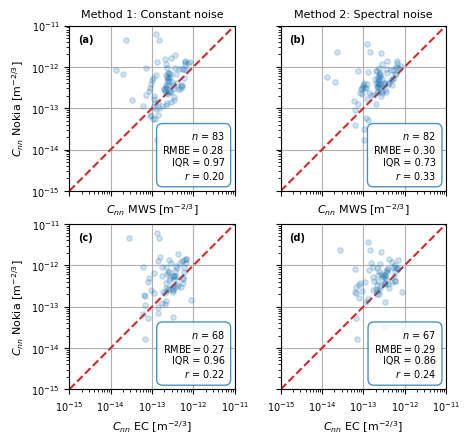

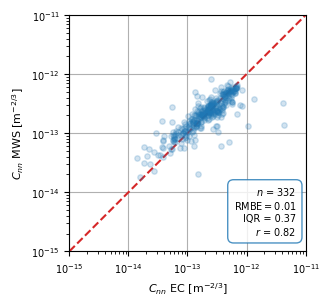

<Figure size 640x480 with 0 Axes>

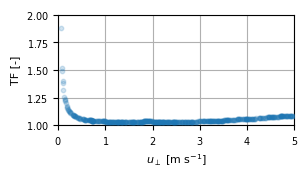

In [7]:
timestep = '30min'
df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_19_02.h5',mode='r')['var_'+timestep]

#Read in Cnn correction for HPF_noise
with open(path_to_proc_data+'constant_noise_19_02.pkl', 'rb') as f:
    dict_corr = pickle.load(f)

pre_corr,post_corr = dict_corr['Pre_Cnn'],dict_corr['Post_Cnn']

val_vs_cal = 'val'

size = 15
nan_filter = 0.25 #if more than this fraction is nans in the timeseries of the Nokia/MWS, timestep will be removed
#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))

df_scatter_Nokia = df_mw_var.loc[:,['MWS', 'Nokia', 'Nokia_det', 'MWS_det', 'MWS_HPF', 'Nokia_HPF', 'Nokia_nans','MWS_nans',
                                    'Nokia_HPF_noise', 'var_noise', 'Nokia_clipped', 'frac_capt_var','Nokia_var_corr','EC_Cnn_10','cal_val_split']]
df_scatter_Nokia['correction_Cnn'] = np.nan
df_scatter_Nokia['correction_Cnn'][:'2023-09-25 11:00'] = pre_corr
df_scatter_Nokia['correction_Cnn']['2023-09-25 15:00':] = post_corr
df_scatter_Nokia['Nokia_HPF_noise'] = variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF'],38*10**9,856,constant_Nokia) - df_scatter_Nokia['correction_Cnn']
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan

df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>Cnn_to_variance_av(6.49*10**-12,38*10**9,856,constant_Nokia)] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>Cnn_to_variance_av(6.49*10**-12,160*10**9,856,constant_MWS)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan

df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=Cnn_to_variance(10**-18,160*10**9,850)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan


df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['F010']>8] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['EC_Cnn_10'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['Nokia_HPF_noise'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['Nokia_var_corr'].loc[df_Nokia_meteo['SWD']<20] = np.nan

df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan
# df_Nokia_meteo.dropna(axis=0,how='any',inplace=True)

if val_vs_cal == 'cal':
    df_Nokia_meteo_plot = df_Nokia_meteo.loc[df_Nokia_meteo['cal_val_split'] == 1]
elif val_vs_cal == 'val':
    df_Nokia_meteo_plot = df_Nokia_meteo.loc[df_Nokia_meteo['cal_val_split'] == 0]
else:
    print('error: no val/cal')

#####################################################
########  Comparison Nokia with MWS vs EC ###########
#####################################################

fig,ax = plt.subplots(ncols = 2,nrows=2,figsize = (12/2.54,11/2.54),sharey=True,sharex=True)
[ax1,ax2,ax3,ax4] = ax.ravel()
df_ax = df_Nokia_meteo_plot[['Nokia_HPF_noise','MWS_HPF']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
sigma_HPF_noise = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
RMSE = np.sqrt(np.sum((y_Nokia-x_Nokia)**2)/len(x_Nokia))
bias_HPF_noise = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
print(y_Nokia[y_Nokia==0],x_Nokia[x_Nokia==0])
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
n_HPF_noise = len(x_Nokia)
ax1.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax1.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax1.grid(zorder=0)
ax1.set_ylim(10**-15,10**-11)
ax1.set_xlim(10**-15,10**-11)
ax1.set_title('Method 1: Constant noise',fontsize=8)
ax1.set_xlabel(r'$C_{nn}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax1.set_ylabel(r'$C_{nn}$ Nokia [$\mathrm{m}^{-2/3}$]',fontsize=8)
textstr = '\n'.join((r'$n$ = '+str(len(y_Nokia)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax1.text(0.94, 0.06, textstr, transform=ax1.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

df_ax = df_Nokia_meteo_plot[['Nokia_var_corr','MWS_HPF']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
sigma_var_corr = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
n_var_corr = len(x_Nokia)
bias_var_corr = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
ax2.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax2.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax2.grid(zorder=0)
ax2.set_title('Method 2: Spectral noise',fontsize=8)
ax2.set_xlabel(r'$C_{nn}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
textstr = '\n'.join((r'$n$ = '+str(len(y_Nokia)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax2.text(0.94, 0.06, textstr, transform=ax2.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)


df_ax = df_Nokia_meteo_plot[['Nokia_HPF_noise','EC_Cnn_10']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].astype(float)
x_Nokia = df_ax['EC_Cnn_10'].values.astype(float)
sigma_HPF_noise_EC = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
n_HPF_noise_EC = len(x_Nokia)
bias_HPF_noise_EC = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
ax3.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax3.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax3.grid(zorder=0)
ax3.set_xlabel(r'$C_{nn}$ EC [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax3.set_ylabel(r'$C_{nn}$ Nokia [$\mathrm{m}^{-2/3}$]',fontsize=8)
textstr = '\n'.join((r'$n$ = '+str(len(y_Nokia)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax3.text(0.94, 0.06, textstr, transform=ax3.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

df_ax = df_Nokia_meteo_plot[['Nokia_var_corr','EC_Cnn_10']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = df_ax['EC_Cnn_10'].values.astype(float)
sigma_var_corr_EC = (np.var(y_Nokia-x_Nokia)**0.5)/np.mean(x_Nokia)*100
n_var_corr_EC = len(x_Nokia)
bias_var_corr_EC = (np.sum(y_Nokia-x_Nokia)/len(x_Nokia))/np.mean(x_Nokia)*100
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
ax4.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax4.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax4.grid(zorder=0)
textstr = '\n'.join((r'$n$ = '+str(len(y_Nokia)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax4.text(0.94, 0.06, textstr, transform=ax4.transAxes, fontsize=7, 
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)
ax4.set_xlabel(r'$C_{nn}$ EC [$\mathrm{m}^{-2/3}$]',fontsize=8)

ax1.ticklabel_format(useMathText=True)
ax2.ticklabel_format(useMathText=True)
ax3.ticklabel_format(useMathText=True)
ax4.ticklabel_format(useMathText=True)
ax1.yaxis.get_offset_text().set_fontsize(7)
ax2.yaxis.get_offset_text().set_fontsize(7)
ax3.yaxis.get_offset_text().set_fontsize(7)
ax4.yaxis.get_offset_text().set_fontsize(7)
ax1.xaxis.get_offset_text().set_fontsize(7)
ax2.xaxis.get_offset_text().set_fontsize(7)
ax3.xaxis.get_offset_text().set_fontsize(7)
ax4.xaxis.get_offset_text().set_fontsize(7)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=7,fontweight='semibold',zorder=11) 

ax1.tick_params(labelsize = 7)
ax2.tick_params(labelsize = 7)
ax3.tick_params(labelsize = 7)
ax4.tick_params(labelsize = 7)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')
plt.subplots_adjust(left = 0.13,right=0.95,top = 0.94,bottom = 0.1,wspace=0.2,hspace = 0.2)
# plt.show()
plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Comparison_Variance_Nokia_MWS_38_HPF_noise_snipping_'+timestep+'_24_02_'+val_vs_cal+'.png',dpi=2400)

#####################################################
########  Comparison MWS vs EC ######################
#####################################################
fig,ax = plt.subplots(ncols = 1,nrows=1,figsize = (8/2.54,8/2.54),sharey=True,sharex=True)
df_Nokia_meteo.loc[df_Nokia_meteo['MWS_HPF'] == 0, ['MWS_HPF','EC_Cnn_10']] = np.nan
df_ax = df_Nokia_meteo[['MWS_HPF','EC_Cnn_10']].dropna(axis=0,how='any')
print(df_ax.loc[df_ax['MWS_HPF'] == 0])
y_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
x_Nokia = df_ax['EC_Cnn_10'].values.astype(float)
corr,_ = pearsonr(np.log10(y_Nokia),np.log10(x_Nokia))
iq = np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.9) - np.quantile(np.log10(y_Nokia)-np.log10(x_Nokia),0.1)
bias = np.mean(np.log10(y_Nokia)-np.log10(x_Nokia))
ax.scatter(x_Nokia,y_Nokia,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax.plot([10**-15,1],[10**-15,1],ls = '--',color = 'tab:red',label='1:1')
ax.grid(zorder=0)
ax.set_ylim(10**-15,10**-11)
ax.set_xlim(10**-15,10**-11)
ax.set_xlabel(r'$C_{nn}$ EC [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax.set_ylabel(r'$C_{nn}$ MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)

textstr = '\n'.join((r'$n$ = '+str(len(y_Nokia)),'$\mathrm{RMBE} = $'+'{:.2f}'.format(bias),r'IQR = '+'{:.2f}'.format(iq),r'$r$ = '+'{:.2f}'.format(corr)))
ax.text(0.96, 0.06, textstr, transform=ax.transAxes, fontsize=7,
                verticalalignment='bottom',horizontalalignment='right',multialignment = 'right', bbox=props,zorder=6)

plt.subplots_adjust(left = 0.2,right=0.95,top = 0.94,bottom = 0.2)
ax.tick_params(labelsize = 7)
ax.ticklabel_format(useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(7)
ax.xaxis.get_offset_text().set_fontsize(7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
plt.subplots_adjust(left=0.2,bottom = 0.15,right=0.95,top = 0.95)
plt.show()
plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Comparison_MWS_EC_'+timestep+'_24_02.png',dpi=2400)#png',dpi=300)


#####################################################
########  Transfer function #########################
#####################################################

fig,ax = plt.subplots(ncols = 1,nrows=1,figsize = (8/2.54,4/2.54),sharey=True,sharex=True)
df_ax = df_Nokia_meteo[['u_perp','frac_capt_var']].dropna(axis=0,how='any')
x_Nokia = df_ax['u_perp'].values
y_Nokia = 1/df_ax['frac_capt_var'].values

ax.scatter(x_Nokia,y_Nokia,alpha=0.2,s=10,zorder=3)# c,cmap = 'viridis')
ax.grid(zorder=0)
ax.set_ylim(10**0,2)
ax.set_yticks([1,1.25,1.5,1.75,2])
ax.set_xlim(0,5)
ax.set_xlabel(r'$u_{\perp}$ [m $\mathrm{s}^{-1}$]',fontsize=8)
ax.set_ylabel(r'TF [-]',fontsize=8)
plt.subplots_adjust(left = 0.2,right=0.95,top = 0.94,bottom = 0.2)
ax.tick_params(labelsize = 7)
ax.ticklabel_format(useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(7)
ax.xaxis.get_offset_text().set_fontsize(7)
plt.subplots_adjust(left=0.2,bottom = 0.25,right=0.95,top = 0.95)
plt.show()
# plt.savefig('Figures/TF_values_19_02.pdf')#png',dpi=2400)#png',dpi=300)

## Timeseries

First run previous cell!

                    Nokia_HPF_noise Nokia_var_corr   MWS_HPF EC_Cnn_10  \
2023-09-14 09:30:00             0.0       0.000152  0.000293       0.0   
2023-09-14 11:30:00             0.0       0.000245  0.000858       0.0   
2023-09-14 16:00:00             0.0       0.000155       NaN       NaN   

                            SWD    u_perp  cal_val_split  
2023-09-14 09:30:00  558.244812  0.860649            0.0  
2023-09-14 11:30:00  690.689148  0.663182            0.0  
2023-09-14 16:00:00  196.867233  0.929313            0.0  
                        Nokia Nokia_HPF_noise Nokia_var_corr   MWS_HPF  \
2023-10-08 12:00:00  0.000799             NaN        0.00004  0.000071   
2023-10-08 12:30:00  0.000707             0.0       0.000034  0.000087   
2023-10-08 14:00:00  0.000766             0.0       0.000062  0.000101   
2023-10-08 16:00:00  0.000716             0.0       0.000041       NaN   

                    EC_Cnn_10  RAIN         SWD    u_perp  cal_val_split  
2023-10-08 12:00:00  

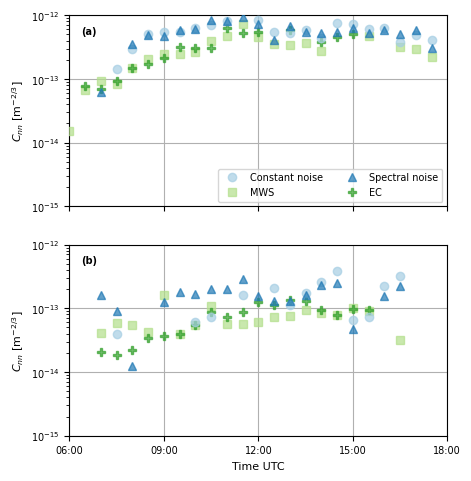

In [40]:
fig,[ax1,ax2] = plt.subplots(ncols = 1,nrows=2,figsize = (12/2.54,12/2.54))

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']

# Sunny day
df_ax_14 = df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr','MWS_HPF','EC_Cnn_10','SWD','u_perp','cal_val_split']]['2023-09-14 00:00':'2023-09-15 00:00']
print(df_ax_14.loc[df_ax_14['cal_val_split'] == 0])
Nokia_1 = df_ax_14['Nokia_HPF_noise'].astype(float)
Nokia_2 = variance_to_Cnn_av(df_ax_14['Nokia_var_corr'],38*10**9,856,constant_Nokia).astype(float)
MWS = variance_to_Cnn_av(df_ax_14['MWS_HPF'],160*10**9,856,constant_MWS).astype(float)
EC = df_ax_14['EC_Cnn_10'].astype(float)

ax1.plot(Nokia_1.index,Nokia_1.values,marker = 'o',color = colors[0],label = r'Constant noise',lw=0,alpha=0.7,zorder=4)
ax1.plot(MWS.index,MWS.values,marker='s',color = colors[2],label = 'MWS',lw=0,alpha=0.7,zorder=3)
ax1.plot(Nokia_2.index,Nokia_2.values,marker = '^',color = colors[1],label = r'Spectral noise',lw=0,alpha=0.7,zorder=4)
ax1.plot(EC.index,EC.values,marker='P',color = colors[3],label = 'EC',lw=0,alpha=0.7,zorder=3)
ax1.grid(zorder=0)
ax1.set_ylim(10**-15,10**-12)
ax1.set_xlim(pd.to_datetime('2023-09-14 06:00'),pd.to_datetime('2023-09-14 18:00'))
ax1.set_ylabel(r'$C_{nn}$ [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax1.set_yscale('log')
ax1.legend(fontsize=7,loc=4,ncol=2)


#Cloudy day
df_ax_08 = df_Nokia_meteo[['Nokia','Nokia_HPF_noise','Nokia_var_corr','MWS_HPF','EC_Cnn_10','RAIN','SWD','u_perp','cal_val_split']]['2023-10-09 00:00':'2023-10-10 00:00']
Nokia_1 = df_ax_08['Nokia_HPF_noise'].astype(float)
Nokia_2 = variance_to_Cnn_av(df_ax_08['Nokia_var_corr'],38*10**9,856,constant_Nokia).astype(float)
MWS = variance_to_Cnn_av(df_ax_08['MWS_HPF'],160*10**9,856,constant_MWS).astype(float)
EC = df_ax_08['EC_Cnn_10'].astype(float)

ax2.plot(Nokia_1.index,Nokia_1.values,marker = 'o',color = colors[0],label = 'Basic',lw=0,alpha=0.7,zorder=3)
ax2.plot(Nokia_2.index,Nokia_2.values,marker = '^',color = colors[1],label = 'Extended',lw=0,alpha=0.7,zorder=3)
ax2.plot(MWS.index,MWS.values,marker='s',color = colors[2],label = 'MWS',lw=0,alpha=0.7,zorder=2)
ax2.plot(EC.index,EC.values,marker='P',color = colors[3],label = 'EC',lw=0,alpha=0.7,zorder=2)
# ax2.plot(df_ax_17.index,df_ax_17['RAIN'].values)
ax2.fill_between(df_Nokia_meteo.index,10**-15,10,where = df_Nokia_meteo['RAIN'] > 0.1,facecolor='gray',alpha=0.2)
ax2.grid(zorder=0)
ax2.set_yscale('log')
ax2.set_ylim(10**-15,10**-12)
ax2.set_xlim(pd.to_datetime('2023-10-09 06:00'),pd.to_datetime('2023-10-09 18:00'))

ax2.set_xlabel(r'Time UTC',fontsize=8)
ax2.set_ylabel(r'$C_{nn}$ [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax1.text(0.03, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.03, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 

ax1.tick_params(labelsize = 7,labelbottom=False)
ax2.tick_params(labelsize = 7)
ticks = pd.date_range(start = '2023-10-09 06:00',end = '2023-10-09 18:00', periods = 5).strftime('%Y-%m-%d %H:%M:%S')
tick_labels = pd.date_range(start = '2023-10-09 06:00',end = '2023-10-09 18:00', periods = 5).strftime('%H:%M')
ax2.set_xticks(ticks)
ax2.set_xticklabels(tick_labels,fontsize=7)#, va = ticklabel_va)
ticks = pd.date_range(start = '2023-09-14 06:00',end = '2023-09-14 18:00', periods = 5).strftime('%Y-%m-%d %H:%M:%S')
tick_labels = pd.date_range(start = '2023-09-14 06:00',end = '2023-09-14 18:00', periods = 5).strftime('%H:%M')
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels,fontsize=7)#, va = ticklabel_va)


ax2.set_xlim(pd.to_datetime('2023-10-09 06:00'),pd.to_datetime('2023-10-09 18:00'))
ticks = pd.date_range(start = '2023-10-09 06:00',end = '2023-10-09 18:00', periods = 5).strftime('%Y-%m-%d %H:%M:%S')
tick_labels = pd.date_range(start = '2023-10-09 06:00',end = '2023-10-09 18:00', periods = 5).strftime('%H:%M')
ax2.set_xticks(ticks)
ax2.set_xticklabels(tick_labels,fontsize=7)#, va = ticklabel_va)

fig.align_ylabels()
plt.subplots_adjust(left=0.15,right=0.95,top=0.97,bottom=0.08,hspace=0.2)
plt.show()
# plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Timeseries_estimates_19_02.pdf')

## Performance vs Temp and wind etc.

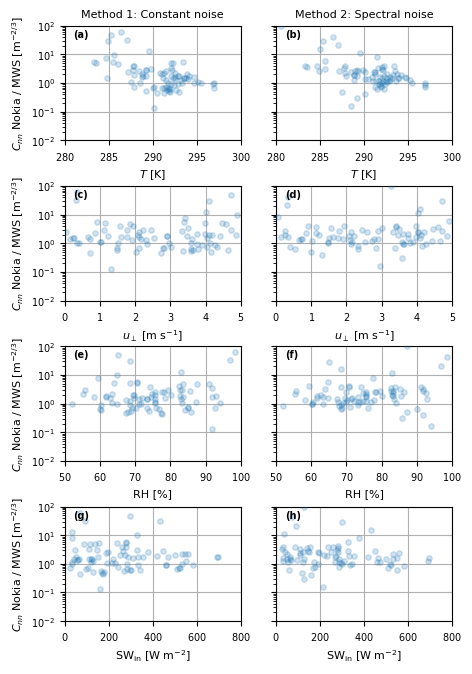

In [56]:
timestep = '30min'

df_mw_var = pd.HDFStore(path_to_proc_data+'var_'+timestep+'_timeseries_frequency_Nokia_corr_MWS_38GHz_19_02.h5',mode='r')['var_'+timestep]

#Read in Cnn correction for HPF_noise
with open(path_to_proc_data+'constant_noise_19_02.pkl', 'rb') as f:
    dict_corr = pickle.load(f)
pre_corr,post_corr = dict_corr['Pre_Cnn'],dict_corr['Post_Cnn']

# What part of data do you want to plot?
val_vs_cal = 'val'

size = 15

#Read Knmi data
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))

df_scatter_Nokia = df_mw_var.loc[:,['MWS', 'Nokia', 'Nokia_det', 'MWS_det', 'MWS_HPF', 'Nokia_HPF', 'Nokia_nans','MWS_nans',
                                    'Nokia_HPF_noise', 'var_noise', 'Nokia_clipped', 'frac_capt_var','Nokia_var_corr','EC_Cnn_10','cal_val_split']]
df_scatter_Nokia['correction_Cnn'] = np.nan
df_scatter_Nokia['correction_Cnn'][:'2023-09-25 11:00'] = pre_corr
df_scatter_Nokia['correction_Cnn']['2023-09-25 15:00':] = post_corr
df_scatter_Nokia['Nokia_HPF_noise'] = variance_to_Cnn_av(df_scatter_Nokia['Nokia_HPF'],38*10**9,856,constant_Nokia) - df_scatter_Nokia['correction_Cnn']
df_scatter_Nokia['MWS_det'].loc[df_scatter_Nokia['MWS_det']>0.003] = np.nan

df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']>Cnn_to_variance_av(6.49*10**-12,38*10**9,856,constant_Nokia)] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']>Cnn_to_variance_av(6.49*10**-12,160*10**9,856,constant_MWS)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']>6.49*10**-12] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']>6.49*10**-12] = np.nan

df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_var_corr']<=0.] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_HPF_noise']<=0.] = np.nan
df_scatter_Nokia['MWS_HPF'].loc[df_scatter_Nokia['MWS_HPF']<=Cnn_to_variance(10**-18,160*10**9,850)] = np.nan
df_scatter_Nokia['EC_Cnn_10'].loc[df_scatter_Nokia['EC_Cnn_10']<=0.] = np.nan
df_scatter_Nokia['Nokia_var_corr'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan
df_scatter_Nokia['Nokia_HPF_noise'].loc[df_scatter_Nokia['Nokia_nans']/(sr_Nokia*60*30) > nan_filter] = np.nan

df_Nokia_meteo = pd.merge(df_scatter_Nokia,df_met_mean,how = 'outer',left_index=True,right_index=True)
df_Nokia_meteo['RAIN_30min'] = df_Nokia_meteo['RAIN']*3
df_Nokia_meteo['RAIN_30min_prev'] = df_Nokia_meteo['RAIN_30min'].shift(1)
df_Nokia_meteo['RAIN_30min_prev2'] = df_Nokia_meteo['RAIN_30min'].shift(2)
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['RAIN_30min_prev2']>0.1/2] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['F010']>8] = np.nan
df_Nokia_meteo['MWS_HPF'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['EC_Cnn_10'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['Nokia_HPF_noise'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo['Nokia_var_corr'].loc[df_Nokia_meteo['SWD']<20] = np.nan
df_Nokia_meteo[['Nokia_HPF_noise','Nokia_var_corr']].loc['2023-09-25 11:00':'2023-09-25 15:00'] = np.nan

if val_vs_cal == 'cal':
    df_Nokia_meteo_plot = df_Nokia_meteo.loc[df_Nokia_meteo['cal_val_split'] == 1]
elif val_vs_cal == 'val':
    df_Nokia_meteo_plot = df_Nokia_meteo.loc[df_Nokia_meteo['cal_val_split'] == 0]
else:
    print('error: no val/cal')


fig,ax = plt.subplots(ncols = 2,nrows=4,figsize = (12/2.54,18/2.54),sharey=True,sharex=False)
[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] = ax.ravel()
df_ax = df_Nokia_meteo_plot[['Nokia_HPF_noise','MWS_HPF','TA002']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia

ax1.scatter(df_ax['TA002'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax1.grid(zorder=0)
ax1.set_ylim(10**-2,10**2)
ax1.set_title('Method 1: Constant noise',fontsize=8)
ax1.set_xlabel(r'$T$ [K]',fontsize=8)
ax1.set_ylabel(r'$C_{nn}$ Nokia / MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax1.set_xlim(280,300)

df_ax = df_Nokia_meteo_plot[['Nokia_var_corr','MWS_HPF','TA002']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax2.scatter(df_ax['TA002'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax2.grid(zorder=0)
ax2.set_xlabel(r'$T$ [K]',fontsize=8)
ax2.set_xlim(280,300)
ax2.set_title('Method 2: Spectral noise',fontsize=8)

df_ax = df_Nokia_meteo_plot[['Nokia_HPF_noise','MWS_HPF','u_perp']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax3.scatter(df_ax['u_perp'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax3.grid(zorder=0)
ax3.set_xlabel(r'$u_{\perp}$ [m s$^{-1}$]',fontsize=8)
ax3.set_ylabel(r'$C_{nn}$ Nokia / MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax3.set_xlim(0,5)

df_ax = df_Nokia_meteo_plot[['Nokia_var_corr','MWS_HPF','u_perp']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax4.scatter(df_ax['u_perp'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax4.grid(zorder=0)
ax4.set_xlabel(r'$u_{\perp}$ [m s$^{-1}$]',fontsize=8)
ax4.set_xlim(0,5)

df_ax = df_Nokia_meteo_plot[['Nokia_HPF_noise','MWS_HPF','RH002']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax5.scatter(df_ax['RH002'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax5.grid(zorder=0)
ax5.set_xlabel(r'RH [%]',fontsize=8)
ax5.set_ylabel(r'$C_{nn}$ Nokia / MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax5.set_xlim(50,100)

df_ax = df_Nokia_meteo_plot[['Nokia_var_corr','MWS_HPF','RH002']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax6.scatter(df_ax['RH002'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax6.grid(zorder=0)
ax6.set_xlabel(r'RH [%]',fontsize=8)
ax6.set_xlim(50,100)

df_ax = df_Nokia_meteo_plot[['Nokia_HPF_noise','MWS_HPF','SWD']].dropna(axis=0,how='any')
y_Nokia = df_ax['Nokia_HPF_noise'].astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax7.scatter(df_ax['SWD'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax7.grid(zorder=0)
ax7.set_xlabel(r'SW$_{\mathrm{in}}$ [W m$^{-2}$]',fontsize=8)
ax7.set_ylabel(r'$C_{nn}$ Nokia / MWS [$\mathrm{m}^{-2/3}$]',fontsize=8)
ax7.set_xlim(0,800)

df_ax = df_Nokia_meteo_plot[['Nokia_var_corr','MWS_HPF','SWD']].dropna(axis=0,how='any')
y_Nokia = variance_to_Cnn_av(df_ax['Nokia_var_corr'].values,38*10**9,856,constant_Nokia).astype(float)
x_Nokia = variance_to_Cnn_av(df_ax['MWS_HPF'].values,160*10**9,856,constant_MWS).astype(float)
residual = y_Nokia/x_Nokia
ax8.scatter(df_ax['SWD'],residual,alpha=0.2,s=size,zorder=3)# c,cmap = 'viridis')
ax8.grid(zorder=0)
ax8.set_xlabel(r'SW$_{\mathrm{in}}$ [W m$^{-2}$]',fontsize=8)
ax8.set_xlim(0,800)

ax1.ticklabel_format(useMathText=True)
ax2.ticklabel_format(useMathText=True)
ax3.ticklabel_format(useMathText=True)
ax4.ticklabel_format(useMathText=True)
ax5.ticklabel_format(useMathText=True)
ax6.ticklabel_format(useMathText=True)
ax7.ticklabel_format(useMathText=True)
ax8.ticklabel_format(useMathText=True)
ax1.yaxis.get_offset_text().set_fontsize(7)
ax2.yaxis.get_offset_text().set_fontsize(7)
ax3.yaxis.get_offset_text().set_fontsize(7)
ax4.yaxis.get_offset_text().set_fontsize(7)
ax5.yaxis.get_offset_text().set_fontsize(7)
ax6.yaxis.get_offset_text().set_fontsize(7)
ax7.yaxis.get_offset_text().set_fontsize(7)
ax8.yaxis.get_offset_text().set_fontsize(7)
ax1.xaxis.get_offset_text().set_fontsize(7)
ax2.xaxis.get_offset_text().set_fontsize(7)
ax3.xaxis.get_offset_text().set_fontsize(7)
ax4.xaxis.get_offset_text().set_fontsize(7)
ax5.xaxis.get_offset_text().set_fontsize(7)
ax6.xaxis.get_offset_text().set_fontsize(7)
ax7.xaxis.get_offset_text().set_fontsize(7)
ax8.xaxis.get_offset_text().set_fontsize(7)
# ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.text(0.05, 0.9, '(a)', transform=ax1.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax2.text(0.05, 0.9, '(b)', transform=ax2.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax3.text(0.05, 0.9, '(c)', transform=ax3.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax4.text(0.05, 0.9, '(d)', transform=ax4.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax5.text(0.05, 0.9, '(e)', transform=ax5.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax6.text(0.05, 0.9, '(f)', transform=ax6.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax7.text(0.05, 0.9, '(g)', transform=ax7.transAxes, fontsize=7,fontweight='semibold',zorder=11) 
ax8.text(0.05, 0.9, '(h)', transform=ax8.transAxes, fontsize=7,fontweight='semibold',zorder=11) 

ax1.tick_params(labelsize = 7)
ax2.tick_params(labelsize = 7)
ax3.tick_params(labelsize = 7)
ax4.tick_params(labelsize = 7)
ax5.tick_params(labelsize = 7)
ax6.tick_params(labelsize = 7)
ax7.tick_params(labelsize = 7)
ax8.tick_params(labelsize = 7)

plt.subplots_adjust(left = 0.13,right=0.95,top = 0.94,bottom = 0.1,wspace=0.2,hspace = 0.4)
# plt.show()
plt.savefig('Figures/Scatter_Nokia_MWS_meteo/Comparison_Variance_Nokia_MWS_38_HPF_20_02_temp_wind_dep_'+val_vs_cal+'.pdf')#,dpi=2400)

## Fraction sctintillations above 1 Hz

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6
 3.8 4.  4.2 4.4 4.6 4.8 5. ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0.99998866 0.99895603 0.99323509 0.98298531 0.96632794 0.94497935
 0.92247107 0.89587013 0.8595235  0.81485464 0.77051514 0.72383214
 0.68189543 0.64042352 0.60479639 0.56958402 0.53892834 0.51157514
 0.48496393 0.46186797 0.44119414 0.42108648 0.40247465 0.38659881
 0.37136125]


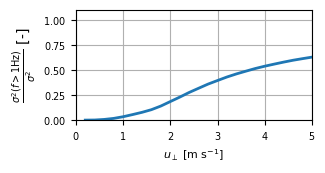

In [133]:
u_perp_list = np.arange(0.2,5.2,0.2)
frac_list = np.zeros_like(u_perp_list)
print(u_perp_list,frac_list)

for i in range(0,len(u_perp_list)):
    frac_list[i] = var_frac_capt_double(0.00001,1,NokiaAp,Nokia_f,856,u_perp_list[i],10**(-13))
print(frac_list)
fig,ax = plt.subplots(ncols = 1,nrows=1,figsize = (8/2.54,4/2.54),sharey=True,sharex=True)

ax.plot(u_perp_list,1-frac_list,lw=2,color = 'tab:blue')# c,cmap = 'viridis')
ax.grid(zorder=0)
ax.set_ylim(0,1.1)
# ax.set_yticks([1,1.25,1.5,1.75,2])
ax.set_xlim(0,5)
ax.set_xlabel(r'$u_{\perp}$ [m $\mathrm{s}^{-1}$]',fontsize=8)
ax.set_ylabel(r'$\frac{\sigma^2(f>1 \mathrm{Hz})}{\sigma^2}$ [-]')
# ax.set_ylabel(r'fraction scintillations f < 1 Hz [-]',fontsize=8)
plt.subplots_adjust(left = 0.2,right=0.95,top = 0.94,bottom = 0.2)
ax.tick_params(labelsize = 7)
ax.ticklabel_format(useMathText=True)
ax.yaxis.get_offset_text().set_fontsize(7)
ax.xaxis.get_offset_text().set_fontsize(7)
# ax.set_yscale('log')
# ax.set_aspect('equal')
plt.subplots_adjust(left=0.2,bottom = 0.25,right=0.95,top = 0.95)
# plt.show()
plt.savefig('Figures/fraction_values_19_02.pdf')#png',dpi=300)

# Playing around

## Weather plots

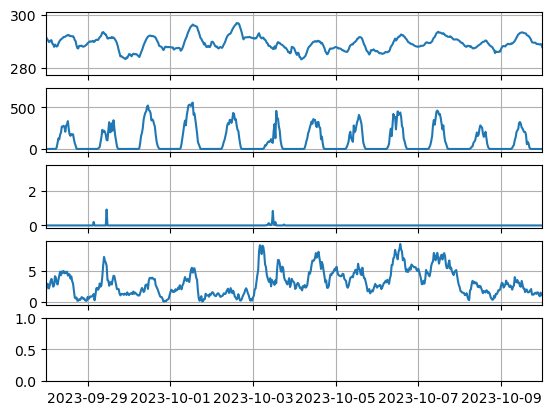

In [43]:
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_met_mean = df_meteo.resample('30min',label='right',closed='right').mean()
alpha = 30 #degrees -- anti clockwise from the north
u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
df_met_mean['u_perp'] = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))

fig,[ax1,ax2,ax3,ax4,ax5] = plt.subplots(nrows = 5,sharex=True)
ax1.plot(df_met_mean.index,df_met_mean['TA002'])
ax2.plot(df_met_mean.index,df_met_mean['SWD'])
ax3.plot(df_met_mean.index,df_met_mean['RAIN'])
ax4.plot(df_met_mean.index,df_met_mean['u_perp'])
# ax5.plot(df_met_mean.index,df_met_mean['TA002'])
ax1.set_xlim(pd.to_datetime('2023-09-28'),pd.to_datetime('2023-10-10'))
for i in [ax1,ax2,ax3,ax4,ax5]:
    i.grid()


## EC behaviour

In [ ]:
timestep = '30min'
start_time, end_time = '2023-09-11 00:00','2023-10-18 00:00'
day_list = pd.date_range(start = start_time, end = end_time,freq = '1D').strftime('%y%m%d')


#Read Knmi data
df_meteo = pd.read_pickle(path_to_KNMI+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'.pkl')
df_mw_var = pd.DataFrame(columns = ['MWS','Nokia','Nokia_det','MWS_det','MWS_HPF','Nokia_HPF','Nokia_HPF_noise','var_noise','Nokia_clipped','frac_capt_var'],index = pd.date_range(start = start_time, end = end_time,freq = timestep))

#Read EC data
EC_files = sorted(os.listdir(path_to_EC))


for j in day_list[:1]:
    print(j)
    store = pd.HDFStore(path_to_proc_data+'Cabauw_'+j+'.h5',mode = 'r')
    df_MWS = store['MWS']#.to_frame()
    df_Nokia_38 = store['Nokia_AGC_38'].to_frame()
    df_MWS['ln_MWS'] = np.log(df_MWS['MWS'])
    df_Nokia_mw = convert_dB_mW(df_Nokia_38)
    df_Nokia_mw['ln_Nokia'] = np.log(convert_dB_mW(df_Nokia_38))
    
    start_day = pd.to_datetime(j,format = '%y%m%d')
    end_day = start_day + timedelta(hours=24)
    time_range = pd.date_range(start = start_day, end = end_day,freq = '1D')
    for i in range(0,len(time_range)-1):
        print(time_range[i])
        df_met_mean = df_meteo[time_range[i]:time_range[i+1]][1:].mean()
        T_mean = df_met_mean['TA002']
        RH_mean = df_met_mean['RH002']
        u_mean = df_met_mean['F010']
        udir_mean = df_met_mean['D010']
        SWD_mean = df_met_mean['SWD']
        alpha = 30 #degrees -- anti clockwise from the north
        u = df_met_mean['F010']*np.sin((df_met_mean['D010']-180)*np.pi/180) #u is positive if it blows east
        v = df_met_mean['F010']*np.cos((df_met_mean['D010']-180)*np.pi/180) #v is positive if it blows north
        u_perp = abs(u*np.cos(alpha*np.pi/180)+v*np.sin(alpha*np.pi/180))
        P_mean = df_met_mean['RAIN']*3
        P0_mean = df_met_mean['P0']

        if (P_mean <= 0.1):
 
            # Compute EC
            df_total_EC = pd.DataFrame()

            string_prefix = 'KTS003_'
            start_file, end_file = string_prefix+datetime.strftime(pd.to_datetime(time_range[i]),"%Y%m%d_%H%M")+'.nc', \
                                    string_prefix+datetime.strftime(pd.to_datetime(time_range[i]+pd.Timedelta(1,'day')),"%Y%m%d_%H%M")+'.nc'
            start_index, end_index = EC_files.index(start_file),EC_files.index(end_file)
    
            for j in EC_files[start_index:end_index]:
                start_date = datetime.strptime(j[-16:-3], '%Y%m%d_%H%M')
                ds = xr.open_dataset(path_to_EC+j)
                time_axis = pd.date_range(start=start_date,periods = ds.sizes['dim_10Hz'],freq = '100ms')
                ds = ds[['LICOR_003-T','LICOR_003-H2O','R3003-u','R3003-v','R3003-w','R3003-r3t']]
                df = ds.to_dataframe()
                df['Date'] = time_axis
                df.set_index('Date',inplace=True)            
                df_total_EC = pd.concat([df_total_EC,df],axis = 0)
            df_total_EC['T'] = df_total_EC['LICOR_003-T']+273.15
            df_total_EC['T_EC'] = df_total_EC['R3003-r3t']/100+273.15
            df_total_EC['q'],df_total_EC['abs_q'],df_total_EC['rho'] = wvd_q(df_total_EC['LICOR_003-H2O'],P0_mean,df_total_EC['T'],RH_mean)
            
            fig,[ax1,ax2,ax3,ax4,ax5] = plt.subplots(nrows = 5,ncols=1,figsize = (15/2.54,30/2.54))
            ax1.plot(df_total_EC.index,df_total_EC['R3003-u'],',')
            ax2.plot(df_total_EC.index,df_total_EC['R3003-v'],',')
            ax3.plot(df_total_EC.index,df_total_EC['R3003-w'],',')
            ax4.plot(df_total_EC.index,df_total_EC['T_EC'],',')
            ax5.plot(df_total_EC.index,df_total_EC['q'],',')
            for k in [ax1,ax2,ax3,ax4,ax5]:
                k.grid()
            # for k in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10][::2]:
            #     k.set_xlim()
            plt.show()
            fig,[ax1,ax2,ax3,ax4,ax5] = plt.subplots(nrows = 5,ncols=1,figsize = (15/2.54,30/2.54))
            ax1.hist(df_total_EC['R3003-u'].values,bins = np.arange(np.nanmin(df_total_EC['R3003-u']),np.nanmax(df_total_EC['R3003-u']),1))
            ax2.hist(df_total_EC['R3003-v'].values,bins = np.arange(np.nanmin(df_total_EC['R3003-v']),np.nanmax(df_total_EC['R3003-v']),1))
            ax3.hist(df_total_EC['R3003-w'].values,bins = np.arange(np.nanmin(df_total_EC['R3003-w']),np.nanmax(df_total_EC['R3003-w']),1))
            ax4.hist(df_total_EC['T_EC'].values,bins = np.arange(np.nanmin(df_total_EC['T_EC']),np.nanmax(df_total_EC['T_EC']),0.01))
            ax5.hist(df_total_EC['q'].values,bins = np.arange(np.nanmin(df_total_EC['q']),np.nanmax(df_total_EC['q']),0.00001))
            for k in [ax1,ax2,ax3,ax4,ax5]:
                k.grid()
            ax1.set_xlabel(r'u [cm s$^{-1}$]')
            ax2.set_xlabel('v [cm s$^{-1}$]')
            ax3.set_xlabel('w [cm s$^{-1}$]')
            ax4.set_xlabel('T [K]')
            ax5.set_xlabel('q [kg kg$^{-1}$]')
            ax1.set_ylabel('Count')
            ax2.set_ylabel('Count')
            ax3.set_ylabel('Count')
            ax4.set_ylabel('Count')
            ax5.set_ylabel('Count')
            ax1.set_xlim(-600,200)
            ax2.set_xlim(-300,300)
            ax3.set_xlim(-100,100)
            ax4.set_xlim(295,315)
            ax5.set_xlim(0.00,0.02)

            plt.subplots_adjust(left = 0.15,right=0.95,top = 0.97,bottom=0.07,hspace=0.3)
            plt.savefig('EC_example_hist_12_7_new.png',dpi=600)
            
           

## Maximum Cnn computation

In [26]:
SWIN = 800*0.8 # Wm-2
Bowen = 0.2
SH = Bowen/(1+Bowen)*SWIN # Wm-2
LvE = 1/(1+Bowen)*SWIN # Wm-2
rho = 1.2 #kg m-3
u_star = 0.2 #m/s
q = 0.015 #kg kg-1
T = 293.15 #K
g = 9.81 
c1_T = 5.6 #After Kooijmans and Hartogensis
c2_T = 6.5
c1_q = 4.5
c2_q = 7.3
z = 10 #m
p = 10**5 #Pa
r_Tq = 0.8
freq_radio = 38*10**9 #Hz
freq_MWS = 160*10**9 #Hz
c = 299792458 #m/s
lambda_radio = c/freq_radio #m
lambda_MWS = c/freq_MWS #m

In [25]:
T_star,q_star,L_Ob = flux_T_q_star_L_Ob(SH,LvE,rho,u_star,T,q)
f_TT,f_qq = f_TT_f_qq(z,L_Ob)
C_TT = f_TT*(T_star**2)/(z**(2/3))
C_qq = f_qq*(q_star**2)/(z**(2/3))
C_Tq = r_Tq*(C_TT*C_qq)**0.5
A_T, A_q =  AT_Aq_Ward(p=p,q=q,T=T)
C_nn = (A_T**2)/(T**2)*C_TT + \
                   (A_q**2)/(q**2)*C_qq + \
                   (2*A_T*A_q)/(T*q)*C_Tq
print(C_nn)

6.491646887073578e-12


# KNMI Data

See KNMI Dataplatform. API script obtained from there

In [ ]:
import logging
import sys
from datetime import datetime

import requests

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel("INFO")

api_url = "https://api.dataplatform.knmi.nl/open-data"
api_version = "v1"

date_start, date_end = '2024-07-02','2024-10-01'
timestamp_start,timestamp_end = datetime.strftime(pd.to_datetime(date_start),"%Y%m%d"),datetime.strftime(pd.to_datetime(date_end),"%Y%m%d")
date_range = pd.date_range(start = timestamp_start,end = timestamp_end,freq = 'd').strftime("%Y%m%d")
print(date_range)
path_to_KNMI_data = 'KNMI/'
        
    

def main():
    # Parameters
    api_key = "eyJvcmciOiI1ZTU1NGUxOTI3NGE5NjAwMDEyYTNlYjEiLCJpZCI6ImYwNjk1Y2E0ZWI1NzRmYTY4YWM4MWRjODY5MmE3MjliIiwiaCI6Im11cm11cjEyOCJ9"
    dataset_names = ['cesar_surface_flux_la1_t10',"cesar_surface_radiation_la1_t10",'cesar_surface_meteo_la1_t10']#,'cesar_surface_flux_la1_t10']# [ceilonet_chm15k_backsct_la1_t05]
    dataset_version = "v1.0"
    for j in range(0,len(dataset_names)):
        dataset_name = dataset_names[j]
        # print(dataset_name)
        for i in range(0,len(date_range)):
            # Use list files request to request first 10 files of the day.
            start_after_filename_prefix = f"{dataset_name}_{dataset_version}_{date_range[i]}"
            print(start_after_filename_prefix)
            list_files_response = requests.get(
                f"{api_url}/{api_version}/datasets/{dataset_name}/versions/{dataset_version}/files",
                headers={"Authorization": api_key},
                params={"startAfterFilename": start_after_filename_prefix},
            )
            list_files = list_files_response.json()

            # logger.info(f"List files response:\n{list_files}")
            dataset_files = list_files.get("files")
            # Retrieve first file in the list files response
            filename = dataset_files[0].get("filename")
            # logger.info(f"Retrieve file with name: {filename}")
            endpoint = f"{api_url}/{api_version}/datasets/{dataset_name}/versions/{dataset_version}/files/{filename}/url"
            get_file_response = requests.get(endpoint, headers={"Authorization": api_key})
            if get_file_response.status_code != 200:
                logger.error("Unable to retrieve download url for file")
                logger.error(get_file_response.text)
                sys.exit(1)

            download_url = get_file_response.json().get("temporaryDownloadUrl")
            download_file_from_temporary_download_url(download_url, filename)


def download_file_from_temporary_download_url(download_url, filename):
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            with open(path_to_KNMI_data+filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception:
        logger.exception("Unable to download file using download URL")
        sys.exit(1)

    # logger.info(f"Successfully downloaded dataset file to {filename}")


if __name__ == "__main__":
    main()


In [10]:
path_to_KNMI_data = 'KNMI/'########Check path!
path_to_proc_KNMI_data = 'KNMI/Processed/' ########Check path!
start_time, end_time = '2023-09-11 00:00','2024-10-01 00:00'
dataset_names = ['cesar_surface_flux_la1_t10',"cesar_surface_radiation_la1_t10",'cesar_surface_meteo_la1_t10']#,'cesar_surface_flux_la1_t10']
dataset_version = "v1.0"
df_total_rad = pd.DataFrame()
df_total_met = pd.DataFrame()
df_total_flux = pd.DataFrame()
df_cloud = pd.DataFrame()
files = sorted(os.listdir(path_to_KNMI_data))
# print(files)
for j in range(0,len(dataset_names)):
    print(dataset_names[j])
    if dataset_names[j] == 'ceilonet_chm15k_backsct_la1_t05':
        string_prefix = dataset_names[j]+'_'+dataset_version+'_06348_A'
    else:    
        string_prefix = dataset_names[j]+'_'+dataset_version+'_'
    start_file, end_file = string_prefix+datetime.strftime(pd.to_datetime(start_time),"%Y%m%d")+'.nc', string_prefix+datetime.strftime(pd.to_datetime(end_time),"%Y%m%d")+'.nc'
    start_index, end_index = files.index(start_file),files.index(end_file)
    
    for i in files[start_index:end_index]:
        start_date = datetime.strptime(i[-11:-3], '%Y%m%d')
        # print(start_date)
        ds = xr.open_dataset(path_to_KNMI_data+i)
        time_axis = pd.date_range(start=start_date,periods = ds.sizes['time'],freq = '10min')
        time_axis_cloud = pd.date_range(start=start_date,periods = ds.sizes['time'],freq = '5min')+pd.Timedelta(5, 'minutes')
        if dataset_names[j] ==  "cesar_surface_radiation_la1_t10":
            ds = ds[['LWD','LWU','SWD','SWU']]
            df = ds.to_dataframe()
            df['Date'] = time_axis
            df.set_index('Date',inplace=True)            
            df_total_rad = pd.concat([df_total_rad,df],axis = 0)
        elif dataset_names[j] == 'cesar_surface_meteo_la1_t10':
            ds = ds[['D010','F010','P0','RAIN','RH002','Q002','TA002','TA000','TD002','ZMA']]
            df = ds.to_dataframe()
            df['Date'] = time_axis
            df.set_index('Date',inplace=True)   
            df_total_met = pd.concat([df_total_met,df],axis = 0)
        elif dataset_names[j] == 'cesar_surface_flux_la1_t10':
            ds = ds[['HSON','LEED','USTAB','USTED','USTPR','WTV','FG0','QNBAL']]
            df = ds.to_dataframe()
            df['Date'] = time_axis
            df.set_index('Date',inplace=True)   
            df_total_flux = pd.concat([df_total_flux,df],axis = 0)
        elif dataset_names[j] == 'ceilonet_chm15k_backsct_la1_t05':
            ds = ds[['cloud_amount']]
            df = ds.to_dataframe()
            df['Date'] = time_axis_cloud
            df.set_index('Date',inplace=True)
            df = df.resample('10min',label='right',closed='right').mean()
            df_cloud = pd.concat([df_cloud,df],axis = 0)
df_total = pd.concat([df_total_met,df_total_rad,df_total_flux,df_cloud],axis=1)
# print(df_total)
df_total.to_pickle(path_to_proc_KNMI_data+'meteo_data_'+start_time[:-6]+'_'+end_time[:-6]+'_09_10.pkl')

cesar_surface_flux_la1_t10
cesar_surface_radiation_la1_t10
cesar_surface_meteo_la1_t10
